# Dokumentasi Model Deteksi & Klasifikasi Esai Siswa dan ChatGPT

Notebook ini bertujuan untuk membangun sistem klasifikasi esai siswa dan ChatPGT menggunakan dua dataset: Student_ChatGPT dan Only_ChatGPT. Sistem ini mencakup arsitektur Bi-Encoder dan classifier untuk membedakan teks dari Student dan ChatGPT. Dokumentasi ini memandu Anda melalui proses pembentukan sistem secara bertahap.

## 1. Import Library

Pada langkah ini, semua library yang diperlukan untuk pemrosesan teks, pembelajaran mesin, dan visualisasi data diimpor:

In [1]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
%load_ext watermark

2025-04-14 18:47:36.012402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744631256.164510     941 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744631256.200866     941 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744631256.530789     941 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744631256.530835     941 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744631256.530837     941 computation_placer.cc:177] computation placer alr

## 2. Load Dataset

Dua dataset utama diimpor:
1. Dataset Student_ChatGPT: Berisi interaksi antara Student dan ChatGPT dengan format:
- Kolom 1: Teks dari Student.
- Kolom 2: Respon dari ChatGPT.
2. Dataset Only_ChatGPT: Berisi teks yang dihasilkan oleh ChatGPT terkait pengetahuan satu mata pelajaran selama satu tahun (2 semester).

Dataset ini digunakan untuk membangun model Bi-Encoder dan classifier.

In [2]:
# Load both datasets
student_chatgpt = pd.read_excel("example_datasets/examples-datasets-mar25.xlsx")
only_chatgpt = pd.read_excel("example_datasets/knowledge-datasets-mar25.xlsx")

In [3]:
# Tampilkan informasi dataset
print("Dataset Student_ChatGPT:")
print(student_chatgpt.info())
print("\nDataset Only_ChatGPT:")
print(only_chatgpt.info())

# Tampilkan beberapa baris awal dataset
print("\nContoh Data Student_ChatGPT:")
display(student_chatgpt.head())

print("\nContoh Data Only_ChatGPT:")
display(only_chatgpt.head())

Dataset Student_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pelajar  43 non-null     object
 1   GPT      43 non-null     object
dtypes: object(2)
memory usage: 820.0+ bytes
None

Dataset Only_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   GPT     118 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB
None

Contoh Data Student_ChatGPT:


,Pelajar,GPT
0,Teknologi adalah segala sesuatu yang menciptak...,Teknologi adalah alat atau sistem yang dicipta...
1,"Sekarang, mari kita lihat fakta umum yang seri...","Dalam kehidupan sehari-hari, teknologi memenga..."
2,"Jika ditelisik lebih jauh, sudah banyak kiprah...","Selain itu, tantangan besar lainnya adalah ban..."
3,Lalu sebenarnya apa saja peran pelajar yang da...,Masyarakat memiliki pandangan yang beragam ter...
4,Salah satu pelajar yang berkiprah dalam menyok...,Salah satu contoh positif dari pemanfaatan tek...



Contoh Data Only_ChatGPT:


,GPT
0,Teknologi adalah sekumpulan pengetahuan dan ke...
1,"Di era digital ini, pelajar menghadapi berbaga..."
2,Masyarakat memiliki pandangan yang beragam ter...
3,Salah satu contoh nyata dari pelajar yang berh...
4,"Namun, untuk dapat berhasil dalam memanfaatkan..."


## 3. Preprocessing Data

Langkah ini memproses data mentah menjadi format yang siap digunakan oleh model:
1. Preprocessing Teks:
- Semua teks diubah menjadi huruf kecil.
- Teks dipisahkan menjadi kalimat menggunakan tokenisasi kalimat.
2. Distribusi Data:
- Total jumlah kalimat dari masing-masing sumber (Student, ChatGPT dari Student_ChatGPT, dan Only_ChatGPT) dihitung dan ditampilkan.

In [4]:
def preprocess_text(text):
    """
    Preprocessing teks:
    - Mengubah teks menjadi huruf kecil.
    - Membagi teks menjadi kalimat (tokenisasi kalimat) menggunakan regex.
    - Tanda baca terakhir (., ?, !) tetap disertakan dalam hasil tokenisasi.

    Args:
        text (str): Teks input.

    Returns:
        list: Daftar kalimat yang telah diproses.
    """
    if not isinstance(text, str) or text.strip() == "":
        return []

    # Ubah teks menjadi huruf kecil dan hilangkan spasi di awal/akhir
    text = text.lower().strip()

    # Tokenisasi kalimat menggunakan regex
    sentences = re.findall(r'.+?[.!?](?=\s|$)', text)
    # Hapus elemen kosong dari hasil split (jika ada)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    return sentences

# Preprocessing data Student_ChatGPT
student_sentences = []
chatgpt_sentences_1 = []  # ChatGPT dari dataset Student_ChatGPT

# Proses teks Student
for text in student_chatgpt['Pelajar']:
    student_sentences.extend(preprocess_text(text))

# Proses teks ChatGPT (dari Student_ChatGPT)
for text in student_chatgpt['GPT']:
    chatgpt_sentences_1.extend(preprocess_text(text))

# Preprocessing data Only_ChatGPT
chatgpt_sentences_2 = []  # ChatGPT dari dataset Only_ChatGPT

# Proses teks ChatGPT (dari Only_ChatGPT)
for text in only_chatgpt['GPT']:
    chatgpt_sentences_2.extend(preprocess_text(text))

# Tampilkan jumlah data hasil preprocessing
print(f"Total kalimat Student: {len(student_sentences)}")
print(f"Total kalimat ChatGPT (Student_ChatGPT): {len(chatgpt_sentences_1)}")
print(f"Total kalimat ChatGPT (Only_ChatGPT): {len(chatgpt_sentences_2)}")

Total kalimat Student: 168
Total kalimat ChatGPT (Student_ChatGPT): 186
Total kalimat ChatGPT (Only_ChatGPT): 413


## 4. Inisialisasi BERT Tokenizer

Teks dari dataset di-tokenisasi menggunakan tokenizer pretrained dari IndoBERT:
- `input_ids`: Token ID untuk setiap kata dalam teks.
- `attention_mask`: Masking untuk menandai kata yang relevan dan padding.

Tokenisasi diperlukan agar teks dapat diproses oleh model BERT.

In [5]:
# Inisialisasi tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Fungsi untuk tokenisasi teks
def tokenize_text(texts, max_length=128):
    """
    Tokenisasi teks menggunakan tokenizer IndoBERT.
    
    Args:
        texts (list): Daftar teks yang akan di-tokenisasi.
        max_length (int): Panjang maksimum token.
        
    Returns:
        dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [6]:
# Tokenisasi data
print("Tokenisasi kalimat Student...")
student_tokens = tokenize_text(student_sentences)

print("Tokenisasi kalimat ChatGPT (Student_ChatGPT)...")
chatgpt_tokens_1 = tokenize_text(chatgpt_sentences_1)

print("Tokenisasi kalimat ChatGPT (Only_ChatGPT)...")
chatgpt_tokens_2 = tokenize_text(chatgpt_sentences_2)

# Tampilkan hasil tokenisasi (contoh: Student)
print("\nContoh hasil tokenisasi:")
print(student_tokens['input_ids'][:1])  # Input token ID
print(student_tokens['attention_mask'][:1])  # Attention mask

Tokenisasi kalimat Student...
Tokenisasi kalimat ChatGPT (Student_ChatGPT)...
Tokenisasi kalimat ChatGPT (Only_ChatGPT)...

Contoh hasil tokenisasi:
tf.Tensor(
[[    2  1429   154  1517  1370    34  2800  7630    41 11811    90   666
  30470     3     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1

I0000 00:00:1744631296.993124     941 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


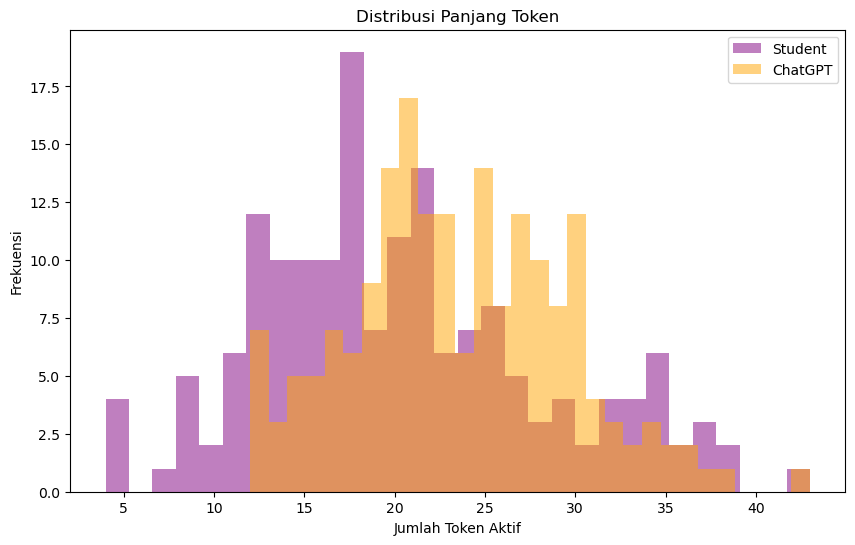

Rata-rata panjang token Student: 20.35
Persentase terpotong Student: 0.00%
Rata-rata panjang token ChatGPT: 23.69
Persentase terpotong ChatGPT: 0.00%


In [11]:
# Memeriksa distribusi panjang token untuk memastikan max_length cukup
student_lengths = [sum(mask) for mask in student_tokens['attention_mask'].numpy()]
chatgpt_lengths = [sum(mask) for mask in chatgpt_tokens_1['attention_mask'].numpy()]

plt.figure(figsize=(10, 6))
plt.hist(student_lengths, bins=30, alpha=0.5, label='Student', color='purple')
plt.hist(chatgpt_lengths, bins=30, alpha=0.5, label='ChatGPT', color='orange')
plt.title('Distribusi Panjang Token')
plt.xlabel('Jumlah Token Aktif')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

print(f"Rata-rata panjang token Student: {np.mean(student_lengths):.2f}")
print(f"Persentase terpotong Student: {sum(l == 128 for l in student_lengths) / len(student_lengths) * 100:.2f}%")
print(f"Rata-rata panjang token ChatGPT: {np.mean(chatgpt_lengths):.2f}")
print(f"Persentase terpotong ChatGPT: {sum(l == 128 for l in chatgpt_lengths) / len(chatgpt_lengths) * 100:.2f}%")

In [12]:
# Mendekode token untuk memastikan tokenisasi berfungsi dengan baik
sample_text = student_sentences[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Teks asli: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Teks asli: teknologi adalah segala sesuatu yang menciptakan efisiensi dan efektivitas untuk manusia.
Token ID: [2, 1429, 154, 1517, 1370, 34, 2800, 7630, 41, 11811, 90, 666, 30470, 3]
Token dekode: [CLS] teknologi adalah segala sesuatu yang menciptakan efisiensi dan efektivitas untuk manusia. [SEP]


In [13]:
# Jika tokenisasi memakan waktu lama, pertimbangkan untuk menyimpannya
tokenized_data = {
    'student': student_tokens,
    'chatgpt_1': chatgpt_tokens_1,
    'chatgpt_2': chatgpt_tokens_2
}

# Menyimpan input_ids dan attention_mask sebagai numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': student_tokens['input_ids'].numpy(),
        'attention_mask': student_tokens['attention_mask'].numpy()
    },
    'chatgpt_1': {
        'input_ids': chatgpt_tokens_1['input_ids'].numpy(),
        'attention_mask': chatgpt_tokens_1['attention_mask'].numpy()
    },
    'chatgpt_2': {
        'input_ids': chatgpt_tokens_2['input_ids'].numpy(),
        'attention_mask': chatgpt_tokens_2['attention_mask'].numpy()
    }
}

with open('tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

## 5. Membuat Model BERT Bi-Encoder

Dua model Bi-Encoder dibuat:
- Bi-Encoder untuk Only_ChatGPT: Digunakan untuk memahami teks dari dataset Only_ChatGPT.
- Bi-Encoder untuk Student_ChatGPT: Digunakan untuk memahami interaksi antara Student dan ChatGPT.

Arsitektur Bi-Encoder melibatkan:
- IndoBERT sebagai backbone untuk menghasilkan embeddings.
- Dense Layers untuk fine-tuning.
- L2 Normalization untuk menghasilkan embeddings yang seragam.

In [14]:
# Load model IndoBERT
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Fungsi untuk membuat Bi-Encoder
def build_bi_encoder(bert_model):
    """
    Membuat model Bi-Encoder dengan IndoBERT.
    
    Args:
        bert_model (TFBertModel): Model dasar IndoBERT.
        
    Returns:
        tf.keras.Model: Model Bi-Encoder.
    """
    # Input layer untuk token ID dan attention mask
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings dari IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer untuk fine-tuning
    dense1 = tf.keras.layers.Dense(128, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(128)(dropout2)
    
    # Normalisasi output (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Model Bi-Encoder
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Buat dua Bi-Encoder
bi_encoder_student_chatgpt = build_bi_encoder(bert_model)
bi_encoder_only_chatgpt = build_bi_encoder(bert_model)

# Tampilkan arsitektur
print("Bi-Encoder untuk Student_ChatGPT:")
bi_encoder_student_chatgpt.summary()

print("\nBi-Encoder untuk Student_ChatGPT:")
bi_encoder_student_chatgpt.summary()

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Bi-Encoder untuk Student_ChatGPT:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7     

## 6. Constrastive Loss

Contrastive loss digunakan untuk melatih Bi-Encoder dengan tujuan:
- Pasangan kalimat yang mirip memiliki nilai similarity tinggi (loss rendah).
- Pasangan kalimat yang tidak mirip memiliki nilai similarity rendah (loss tinggi).

Datasets Student_ChatGPT: variable -> student_sentences & chatgpt_sentences_1
Pasangan Positif:
- Student - Student
- ChatGPT1 - ChatGPT1

Pasangan Negatif:
- Student - ChatGPT1

Datasets Only_ChatGPT: variable -> chatgpt_sentences_2
Pasangan Positif:
- Student - Student
- ChatGPT1 - ChatGPT2

Pasangan Negatif:
- Student - ChatGPT2

In [16]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens_1, chatgpt_tokens_2, max_pairs=None):
    """
    Creates data pairs for contrastive learning with dataset-appropriate quantities.

    Args:
        student_tokens: Tokenized student text
        chatgpt_tokens_1: First set of tokenized ChatGPT text
        chatgpt_tokens_2: Second set of tokenized ChatGPT text
        max_pairs: Maximum number of pairs (optional). If None, uses all possible combinations.

    Returns:
        tuple: Dictionary of anchor, positive, negative pairs and labels, and the total number of pairs.
    """
    # Get dataset sizes
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt_1 = chatgpt_tokens_1['input_ids'].shape[0]
    n_chatgpt_2 = chatgpt_tokens_2['input_ids'].shape[0]
    
    # Calculate maximum possible combinations
    max_student_pairs = (n_student * (n_student - 1)) // 2  # student-student combinations
    max_chatgpt_pairs = (n_chatgpt_1 * (n_chatgpt_1 - 1)) // 2  # chatgpt-chatgpt combinations
    max_negative_pairs = n_student * n_chatgpt_2  # student-chatgpt combinations
    
    # Determine number of pairs to create
    if max_pairs is None:
        # Use minimum number of positive pairs for balance
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Limit negative pairs to balance with positives
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
    else:
        # If max_pairs is specified, use that with equal proportions
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
    
    # Ensure we don't exceed the maximum possible combinations
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)
    
    # Initialize arrays for data pairs
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []
    
    # Generate positive student-student pairs
    if n_pos_student > 0:
        # Create all possible student-student pairs
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Randomly select pairs
        selected_pairs = random.sample(student_pairs, n_pos_student)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (student)
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])
            
            # Positive (another student)
            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])
            
            # Negative (from ChatGPT)
            neg_idx = np.random.choice(n_chatgpt_2)
            negative_input_ids.append(chatgpt_tokens_2['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate positive chatgpt-chatgpt pairs
    if n_pos_chatgpt > 0:
        # Create all possible chatgpt-chatgpt pairs
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt_1) for j in range(i+1, n_chatgpt_1)]
        # Randomly select pairs
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)
        
        for idx1, idx2 in selected_pairs:
            # Anchor (ChatGPT 1)
            anchor_input_ids.append(chatgpt_tokens_1['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens_1['attention_mask'][idx1])
            
            # Positive (ChatGPT 2)
            positive_input_ids.append(chatgpt_tokens_2['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens_2['attention_mask'][idx2])
            
            # Negative (from Student)
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])
            
            # Label (1 for positive pair)
            labels.append(1)
    
    # Generate negative student-chatgpt pairs
    if n_neg_pairs > 0:
        # Create all possible student-chatgpt pairs
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt_2)]
        # Randomly select pairs
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)
        
        for student_idx, chatgpt_idx in selected_pairs:
            # Anchor (Student)
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])
            
            # Negative (ChatGPT)
            negative_input_ids.append(chatgpt_tokens_2['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][chatgpt_idx])
            
            # Positive (another Student different from anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Ensure there are available indices
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])
                
                # Label (0 for negative pair)
                labels.append(0)
    
    # Count actual pairs created
    actual_pairs = len(labels)
    
    # Convert to tensors and return
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs

In [18]:
# Buat pasangan data untuk model Student_ChatGPT tanpa menentukan n_pairs
student_chatgpt_pairs, total_pairs = create_contrastive_pairs(student_tokens, chatgpt_tokens_1, chatgpt_tokens_1)

# Tampilkan jumlah pasangan yang dibuat
print(f"Total contrastive pairs yang dibuat: {total_pairs}")
print(f"- Pasangan positif student-student: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan positif chatgpt-chatgpt: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan negatif student-chatgpt: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 0)}")

Total contrastive pairs yang dibuat: 28056
- Pasangan positif student-student: 7014
- Pasangan positif chatgpt-chatgpt: 7014
- Pasangan negatif student-chatgpt: 14028


In [19]:
# Buat pasangan data untuk model Only_ChatGPT tanpa menentukan n_pairs
only_chatgpt_pairs, total_pairs = create_contrastive_pairs(student_tokens, chatgpt_tokens_1, chatgpt_tokens_2)

# Tampilkan jumlah pasangan yang dibuat
print(f"Total Knowledge GPT pairs yang dibuat: {total_pairs}")
print(f"- Pasangan positif student-student: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan positif chatgpt-chatgpt: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan negatif student-chatgpt: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 0)}")

Total Knowledge GPT pairs yang dibuat: 28056
- Pasangan positif student-student: 7014
- Pasangan positif chatgpt-chatgpt: 7014
- Pasangan negatif student-chatgpt: 14028


In [20]:
# Model untuk training dengan triplet loss
def build_triplet_model(bi_encoder):
    """
    Membangun model untuk training dengan triplet loss.
    
    Args:
        bi_encoder: Model bi-encoder yang akan dilatih.
        
    Returns:
        tf.keras.Model: Model untuk training dengan triplet loss.
    """
    # Input untuk anchor, positive, dan negative
    anchor_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_attention_mask")

    positive_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding untuk anchor, positive, dan negative
    anchor_embedding = bi_encoder([anchor_input_ids, anchor_attention_mask])
    positive_embedding = bi_encoder([positive_input_ids, positive_attention_mask])
    negative_embedding = bi_encoder([negative_input_ids, negative_attention_mask])
    
    # Hitung cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Output model adalah perbedaan similarity
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

In [21]:
# Custom loss function untuk triplet
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: mendorong similarity positif lebih tinggi dari similarity negatif.
    
    Args:
        y_true: Tidak digunakan dalam triplet loss.
        y_pred: Stack dari [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: Nilai loss.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

## 7. Train Bi-Encoder

### 7.1. Training Student - ChatGPT1

In [25]:
# Buat model triplet untuk Student_ChatGPT
triplet_model_student_chatgpt = build_triplet_model(bi_encoder_student_chatgpt)

# Compile model
triplet_model_student_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training Bi-Encoder untuk Student_ChatGPT...")
history_student_chatgpt = triplet_model_student_chatgpt.fit(
    x=[
        student_chatgpt_pairs['anchor']['input_ids'],
        student_chatgpt_pairs['anchor']['attention_mask'],
        student_chatgpt_pairs['positive']['input_ids'],
        student_chatgpt_pairs['positive']['attention_mask'],
        student_chatgpt_pairs['negative']['input_ids'],
        student_chatgpt_pairs['negative']['attention_mask']
    ],
    y=student_chatgpt_pairs['labels'],  # Tidak digunakan dalam triplet loss
    epochs=3,
    batch_size=32,
    validation_split=0.3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training Bi-Encoder untuk Student_ChatGPT...
Epoch 1/3
614/614 [==============================] - 748s 1s/step - loss: 0.3737 - val_loss: 0.1317
Epoch 2/3
614/614 [==============================] - 730s 1s/step - loss: 0.1627 - val_loss: 0.0465
Epoch 3/3
614/614 [==============================] - 745s 1s/step - loss: 0.1032 - val_loss: 0.0120


### 7.2. Training ChatGPT2

In [26]:
# Buat model triplet untuk Only_ChatGPT
triplet_model_only_chatgpt = build_triplet_model(bi_encoder_only_chatgpt)

# Compile model
triplet_model_only_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Only_ChatGPT
print("Training Bi-Encoder untuk Only_ChatGPT...")
history_only_chatgpt = triplet_model_only_chatgpt.fit(
    x=[
        only_chatgpt_pairs['anchor']['input_ids'],
        only_chatgpt_pairs['anchor']['attention_mask'],
        only_chatgpt_pairs['positive']['input_ids'],
        only_chatgpt_pairs['positive']['attention_mask'],
        only_chatgpt_pairs['negative']['input_ids'],
        only_chatgpt_pairs['negative']['attention_mask']
    ],
    y=only_chatgpt_pairs['labels'],  # Tidak digunakan dalam triplet loss
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Training Bi-Encoder untuk Only_ChatGPT...
Epoch 1/3
702/702 [==============================] - 791s 1s/step - loss: 0.3797 - val_loss: 0.1730
Epoch 2/3
702/702 [==============================] - 734s 1s/step - loss: 0.1916 - val_loss: 0.0553
Epoch 3/3
702/702 [==============================] - 735s 1s/step - loss: 0.1240 - val_loss: 0.0194


## 8. Training History

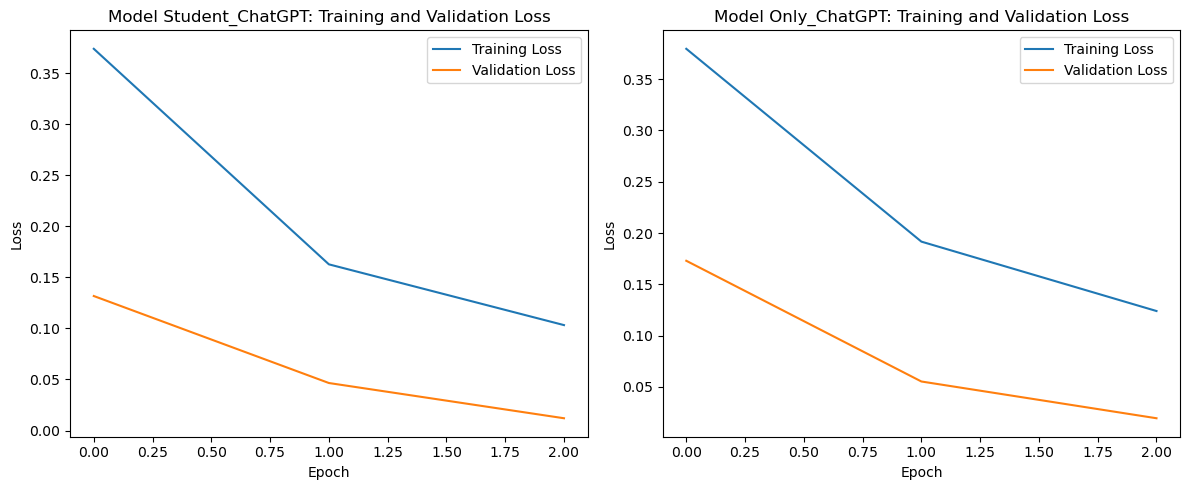

In [31]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_student_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_student_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training history untuk model Only_ChatGPT
plt.subplot(1, 2, 2)
plt.plot(history_only_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_only_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Model Only_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 9. Evaluasi Bi-Encoder

Bi-Encoder dievaluasi dengan menghitung cosine similarity antara embeddings yang dihasilkan:
- Student vs ChatGPT (Student_ChatGPT).
- ChatGPT (Student_ChatGPT) vs ChatGPT (Only_ChatGPT).

Similarity score digunakan untuk memahami seberapa dekat embeddings dari berbagai sumber teks.

In [30]:
# Fungsi untuk menghasilkan embeddings
def generate_embeddings(tokens, model):
    """
    Menghasilkan embeddings untuk teks.
    
    Args:
        tokens: Token dari teks.
        model: Model bi-encoder.
        
    Returns:
        tf.Tensor: Embeddings.
    """
    return model([tokens['input_ids'], tokens['attention_mask']])

In [53]:
# Fungsi untuk menghitung similarity score dengan agregasi maksimum
def compute_similarity_max(embedding1, embedding2):
    """
    Menghitung similarity score dengan metode agregasi maksimum.
    
    Args:
        embedding1: Embedding pertama (teks input).
        embedding2: Embedding kedua (referensi).
        
    Returns:
        float: Similarity score maksimum.
    """
    # Normalisasi embeddings (L2 norm)
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    # Hitung cosine similarity
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])  # Flatten
    
    # Ambil nilai maksimum
    max_similarity = tf.reduce_max(similarities).numpy()
    return max_similarity

In [29]:
def compute_similarity_avg(embedding1, embedding2):
    """
    Menghitung similarity score dengan metode agregasi rata-rata.
    
    Args:
        embedding1: Embedding pertama (teks input).
        embedding2: Embedding kedua (referensi).
        
    Returns:
        float: Similarity score rata-rata.
    """
    # Normalisasi embeddings (L2 norm)
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    # Hitung cosine similarity
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])  # Flatten
    
    # Ambil nilai rata-rata
    avg_similarity = tf.reduce_mean(similarities).numpy()
    return avg_similarity

In [27]:
if not os.path.exists('saved_models_1_2'):
    os.makedirs('saved_models_1_2')

# Simpan model bi-encoder untuk Student_ChatGPT
bi_encoder_student_chatgpt.save('saved_models_1_2/bi_encoder_student_chatgpt.h5')

# Simpan model bi-encoder untuk Only_ChatGPT
bi_encoder_only_chatgpt.save('saved_models_1_2/bi_encoder_only_chatgpt.h5')

# Save tokenizer configuration
tokenizer.save_pretrained('saved_models_1_2/tokenizer')

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


('saved_models_1_2/tokenizer/tokenizer_config.json',
 'saved_models_1_2/tokenizer/special_tokens_map.json',
 'saved_models_1_2/tokenizer/vocab.txt',
 'saved_models_1_2/tokenizer/added_tokens.json')

In [28]:
custom_objects = {'TFBertModel': TFBertModel}

with tf.keras.utils.custom_object_scope(custom_objects):
    # Muat model bi-encoder yang sudah dilatih
    bi_encoder_student_chatgpt = tf.keras.models.load_model('saved_models_1_2/bi_encoder_student_chatgpt.h5')
    bi_encoder_only_chatgpt = tf.keras.models.load_model('saved_models_1_2/bi_encoder_only_chatgpt.h5')

In [32]:
# Inisialisasi tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained('saved_models_1_2/tokenizer')

# Fungsi untuk tokenisasi teks
def tokenize_text(texts, max_length=128):
    """
    Tokenisasi teks menggunakan tokenizer IndoBERT.
    
    Args:
        texts (list): Daftar teks yang akan di-tokenisasi.
        max_length (int): Panjang maksimum token.
        
    Returns:
        dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [33]:
# Tokenisasi data
print("Tokenisasi kalimat Student...")
student_tokens = tokenize_text(student_sentences)

print("Tokenisasi kalimat ChatGPT (Student_ChatGPT)...")
chatgpt_tokens_1 = tokenize_text(chatgpt_sentences_1)

print("Tokenisasi kalimat ChatGPT (Only_ChatGPT)...")
chatgpt_tokens_2 = tokenize_text(chatgpt_sentences_2)

# Tampilkan hasil tokenisasi (contoh: Student)
print("\nContoh hasil tokenisasi:")
print(student_tokens['input_ids'][:1])  # Input token ID
print(student_tokens['attention_mask'][:1])  # Attention mask

Tokenisasi kalimat Student...
Tokenisasi kalimat ChatGPT (Student_ChatGPT)...
Tokenisasi kalimat ChatGPT (Only_ChatGPT)...

Contoh hasil tokenisasi:
tf.Tensor(
[[    2  1429   154  1517  1370    34  2800  7630    41 11811    90   666
  30470     3     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1

In [75]:
def generate_embeddings_in_batches(tokens, model, batch_size=8):
    """Generate embeddings in smaller batches to avoid OOM errors"""
    all_embeddings = []
    total_samples = len(tokens['input_ids'])
    num_batches = (total_samples + batch_size - 1) // batch_size  # Ceiling division
    
    print(f"Processing {total_samples} samples in {num_batches} batches of size {batch_size}")
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch_size_actual = batch_end - i
        
        # Create batch inputs
        batch_input_ids = tokens['input_ids'][i:batch_end]
        batch_attention_mask = tokens['attention_mask'][i:batch_end]
        
        print(f"Processing batch {i//batch_size + 1}/{num_batches} ({batch_size_actual} samples)")
        
        # Generate embeddings for this batch
        batch_embeddings = model.predict(
            [batch_input_ids, batch_attention_mask],
            verbose=0  # Set to 1 for progress bars
        )
        
        all_embeddings.append(batch_embeddings)
    
    # Concatenate all batch embeddings
    return np.vstack(all_embeddings)

# Generate embeddings for Student (Student_ChatGPT)
print("Generating embeddings for Student (Student_ChatGPT)...")
student_embeddings_1 = generate_embeddings_in_batches(student_tokens, bi_encoder_student_chatgpt)

print("Generating embeddings for ChatGPT-1 (Student_ChatGPT)...")
chatgpt_embeddings_1 = generate_embeddings_in_batches(chatgpt_tokens_1, bi_encoder_student_chatgpt)

# Generate embeddings for model 2
print("Generating embeddings for Student (Only_ChatGPT)...")
student_embeddings_1_2 = generate_embeddings_in_batches(student_tokens, bi_encoder_only_chatgpt)

print("Generating embeddings for ChatGPT-1 (Only_ChatGPT)...")
chatgpt_embeddings_1_2 = generate_embeddings_in_batches(chatgpt_tokens_1, bi_encoder_only_chatgpt)

print("Generating embeddings for ChatGPT-2 (Only_ChatGPT)...")
chatgpt_embeddings_2 = generate_embeddings_in_batches(chatgpt_tokens_2, bi_encoder_only_chatgpt)

# Cari jumlah pasangan yang paling sedikit
min_pairs = min(
    student_embeddings_1.shape[0],
    chatgpt_embeddings_1.shape[0],
    chatgpt_embeddings_2.shape[0]
)

# Cari jumlah pasangan yang paling sedikit
min_pairs = min(
    student_embeddings_1.shape[0],
    chatgpt_embeddings_1.shape[0],
    chatgpt_embeddings_2.shape[0]
)

# Pilih secara acak untuk keadilan
np.random.seed(42)
random_indices_student = np.random.choice(student_embeddings_1.shape[0], size=min_pairs, replace=False)
random_indices_chatgpt1 = np.random.choice(chatgpt_embeddings_1.shape[0], size=min_pairs, replace=False)

random_indices_student1_2 = np.random.choice(student_embeddings_1_2.shape[0], size=min_pairs, replace=False)
random_indices_chatgpt1_2= np.random.choice(chatgpt_embeddings_1_2.shape[0], size=min_pairs, replace=False)
random_indices_chatgpt2 = np.random.choice(chatgpt_embeddings_2.shape[0], size=min_pairs, replace=False)

# Convert NumPy indices to TensorFlow tensors
random_indices_student_tf = tf.constant(random_indices_student, dtype=tf.int32)
random_indices_chatgpt1_tf = tf.constant(random_indices_chatgpt1, dtype=tf.int32)

random_indices_student1_2_tf = tf.constant(random_indices_student1_2, dtype=tf.int32)
random_indices_chatgpt1_2_tf = tf.constant(random_indices_chatgpt1_2, dtype=tf.int32)
random_indices_chatgpt2_tf = tf.constant(random_indices_chatgpt2, dtype=tf.int32)

# Potong array agar jumlah pasangan berimbang - using tf.gather
student_emb1_balanced = tf.gather(student_embeddings_1, random_indices_student_tf)
chatgpt1_emb1_balanced = tf.gather(chatgpt_embeddings_1, random_indices_chatgpt1_tf)

student_emb2_balanced = tf.gather(student_embeddings_1_2, random_indices_student1_2_tf)
chatgpt1_emb2_balanced = tf.gather(chatgpt_embeddings_1_2, random_indices_chatgpt1_2_tf)
chatgpt2_emb2_balanced = tf.gather(chatgpt_embeddings_2, random_indices_chatgpt2_tf)

Generating embeddings for Student (Student_ChatGPT)...
Processing 168 samples in 21 batches of size 8
Processing batch 1/21 (8 samples)
Processing batch 2/21 (8 samples)
Processing batch 3/21 (8 samples)
Processing batch 4/21 (8 samples)
Processing batch 5/21 (8 samples)
Processing batch 6/21 (8 samples)
Processing batch 7/21 (8 samples)
Processing batch 8/21 (8 samples)
Processing batch 9/21 (8 samples)
Processing batch 10/21 (8 samples)
Processing batch 11/21 (8 samples)
Processing batch 12/21 (8 samples)
Processing batch 13/21 (8 samples)
Processing batch 14/21 (8 samples)
Processing batch 15/21 (8 samples)
Processing batch 16/21 (8 samples)
Processing batch 17/21 (8 samples)
Processing batch 18/21 (8 samples)
Processing batch 19/21 (8 samples)
Processing batch 20/21 (8 samples)
Processing batch 21/21 (8 samples)
Generating embeddings for ChatGPT-1 (Student_ChatGPT)...
Processing 186 samples in 24 batches of size 8
Processing batch 1/24 (8 samples)
Processing batch 2/24 (8 samples)


In [ ]:
# 1. Similarity dengan Student (dari model Student_ChatGPT)
student_student_sim_scores = []
student_gpt1_sim_scores = []
student_gpt2_sim_scores = []
for emb in student_embeddings_1:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), student_embeddings_1)
    student_student_sim_scores.append(avg_similarity)

    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt_embeddings_1)
    student_gpt1_sim_scores.append(avg_similarity)

# For Knowledge
for emb in student_embeddings_1_2:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt_embeddings_2)
    student_gpt2_sim_scores.append(avg_similarity)


# 2. Similarity dengan ChatGPT (dari model Student_ChatGPT)
gpt1_student_sim_scores = []
gpt1_gpt1_sim_scores = []
gpt1_gpt2_sim_scores = []
for emb in chatgpt_embeddings_1:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), student_embeddings_1)
    gpt1_student_sim_scores.append(avg_similarity)

    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt_embeddings_1)
    gpt1_gpt1_sim_scores.append(avg_similarity)

# For Knowledge
for emb in chatgpt_embeddings_1_2:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt_embeddings_2)
    gpt1_gpt2_sim_scores.append(avg_similarity)

# 3. Similarity dengan ChatGPT Knowledge (dari model Only_ChatGPT)
gpt2_student_sim_scores = []
gpt2_gpt1_sim_scores = []
gpt2_gpt2_sim_scores =[]
for emb in chatgpt_embeddings_2:
    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), student_embeddings_1_2)
    gpt2_student_sim_scores.append(avg_similarity)

    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt_embeddings_1_2)
    gpt2_gpt1_sim_scores.append(avg_similarity)

    avg_similarity = compute_similarity_avg(tf.expand_dims(emb, 0), chatgpt_embeddings_2)
    gpt2_gpt2_sim_scores.append(avg_similarity)

# Konversi ke numpy arrays
student_similarity_scores = np.array([student_student_sim_scores, student_gpt1_sim_scores, student_gpt2_sim_scores])
chatgpt1_similarity_scores = np.array([gpt1_student_sim_scores, gpt1_gpt1_sim_scores, gpt1_gpt2_sim_scores])
chatgpt2_similarity_scores = np.array([gpt2_student_sim_scores, gpt2_gpt1_sim_scores, gpt2_gpt2_sim_scores])

# Hitung jumlah similarity scores untuk masing-masing kategori
num_student_scores = student_similarity_scores.size
num_chatgpt1_scores = chatgpt1_similarity_scores.size
num_chatgpt2_scores = chatgpt2_similarity_scores.size

# Tampilkan hasil
print(f"Jumlah similarity scores untuk Student (imbalanced): {num_student_scores}")
print(f"Jumlah similarity scores untuk ChatGPT1(imbalanced): {num_chatgpt1_scores}")
print(f"Jumlah similarity scores untuk ChatGPT2(imbalanced): {num_chatgpt2_scores}")

# Cari jumlah pasangan yang paling sedikit
min_pairs = min(
    student_similarity_scores.shape[1],
    chatgpt1_similarity_scores.shape[1],
    chatgpt2_similarity_scores.shape[1]
)

# Pilih secara acak untuk keadilan
np.random.seed(42)
random_indices_student = np.random.choice(student_similarity_scores.shape[1], size=min_pairs, replace=False)
random_indices_chatgpt1 = np.random.choice(chatgpt1_similarity_scores.shape[1], size=min_pairs, replace=False)
random_indices_chatgpt2 = np.random.choice(chatgpt2_similarity_scores.shape[1], size=min_pairs, replace=False)

# Potong array agar jumlah pasangan berimbang
student_similarity_scores_balanced = student_similarity_scores[:, random_indices_student]
chatgpt1_similarity_scores_balanced = chatgpt1_similarity_scores[:, random_indices_chatgpt1]
chatgpt2_similarity_scores_balanced = chatgpt2_similarity_scores[:, random_indices_chatgpt2]
# Tampilkan hasil
print(f"Jumlah pasangan setelah penyeimbangan: {min_pairs}")

# Hitung jumlah similarity scores untuk masing-masing kategori
num_student_scores_balanced = student_similarity_scores_balanced.size
num_chatgpt1_scores_balanced = chatgpt1_similarity_scores_balanced.size
num_chatgpt2_scores_balanced = chatgpt2_similarity_scores_balanced.size

# Tampilkan hasil
print(f"Jumlah similarity scores untuk Student (balanced): {num_student_scores_balanced}")
print(f"Jumlah similarity scores untuk ChatGPT1(balanced): {num_chatgpt1_scores_balanced}")
print(f"Jumlah similarity scores untuk ChatGPT2(balanced): {num_chatgpt2_scores_balanced}")

print(student_similarity_scores_balanced.shape)
print(chatgpt1_similarity_scores_balanced.shape)
print(chatgpt2_similarity_scores_balanced.shape)

# Simpan similarity scores untuk digunakan dalam klasifikasi
reference_embeddings_1 = {
    'student': {
        'embeddings': student_embeddings_1,  
        'similarity_scores': student_similarity_scores
    },
    'chatgpt': {
        'embeddings': chatgpt_embeddings_1,  
        'similarity_scores': chatgpt1_similarity_scores
    }
}

reference_embeddings_2 = {
    'chatgpt_knowledge': {
        'embeddings': chatgpt_embeddings_2,
        'similarity_scores': chatgpt2_similarity_scores
    }
}

Jumlah similarity scores untuk Student (imbalanced): 504
Jumlah similarity scores untuk ChatGPT1(imbalanced): 558
Jumlah similarity scores untuk ChatGPT2(imbalanced): 1239
Jumlah pasangan setelah penyeimbangan: 168
Jumlah similarity scores untuk Student (balanced): 504
Jumlah similarity scores untuk ChatGPT1(balanced): 504
Jumlah similarity scores untuk ChatGPT2(balanced): 504
(3, 168)
(3, 168)
(3, 168)


In [ ]:
# Combine student and ChatGPT similarity scores
student_similarity_df = pd.DataFrame({
    'student_text': student_sentences,
    'chatgpt_text': chatgpt_sentences_1,
    'similarity_score': student_gpt1_sim_scores
})

# Sort by similarity score in descending order
top_5_similarities = student_similarity_df.sort_values(by='similarity_score', ascending=False).head(5)

# Display the top 5 results
print("Top 5 Student Essays with Highest Similarity Scores:")
display(top_5_similarities)

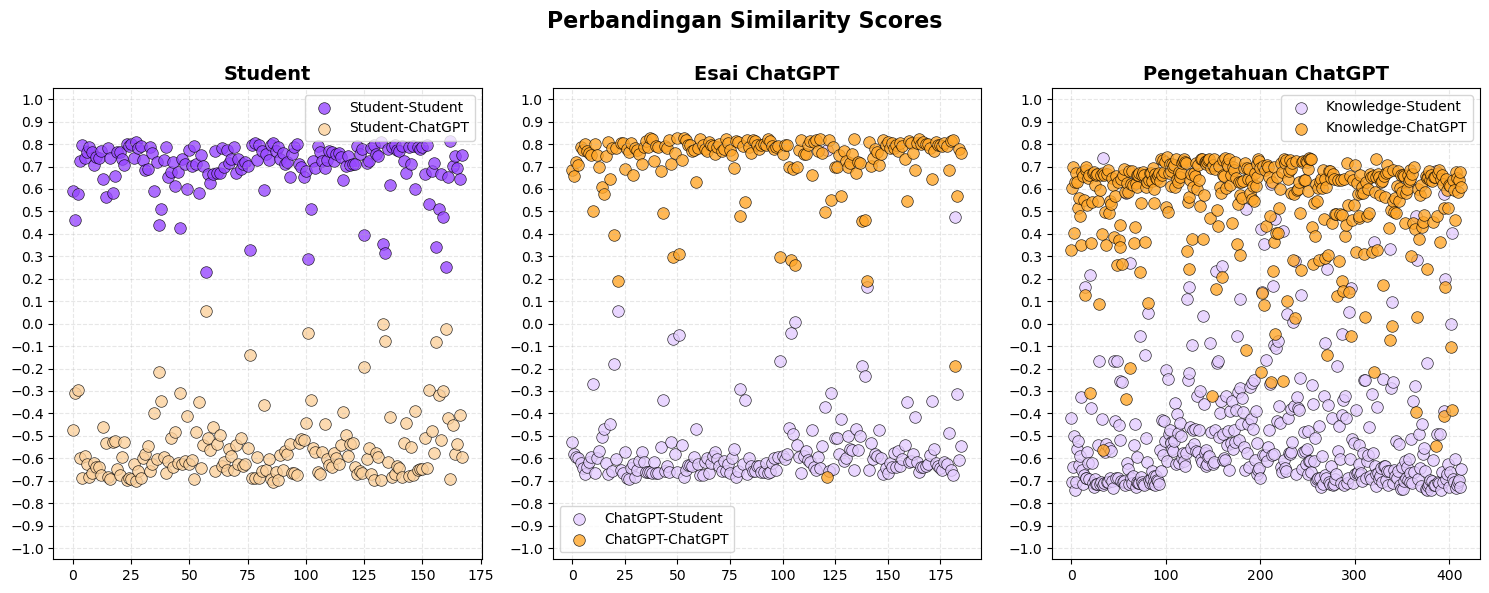

In [63]:
plt.figure(figsize=(15, 6))

student_student_color = "#9747FF"  
student_chatgpt_color = "#FCD19C"  
chatgpt_chatgpt_color = "#FFA629"  
chatgpt_student_color = "#E4CCFF"  

# Subplot 1: Student
plt.subplot(1, 3, 1)
plt.scatter(range(len(student_student_sim_scores)), student_student_sim_scores, 
            label='Student-Student', color=student_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(student_gpt1_sim_scores)), student_gpt1_sim_scores, 
            label='Student-ChatGPT', color=student_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Student', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 2: Esai ChatGPT
plt.subplot(1, 3, 2)
plt.scatter(range(len(gpt1_student_sim_scores)), gpt1_student_sim_scores, 
            label='ChatGPT-Student', color=chatgpt_student_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.scatter(range(len(gpt1_gpt1_sim_scores)), gpt1_gpt1_sim_scores, 
            label='ChatGPT-ChatGPT', color=chatgpt_chatgpt_color, s=70, alpha=0.8, edgecolor='black', linewidth=0.5)
plt.title('Esai ChatGPT', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

# Subplot 3: Pengetahuan ChatGPT
plt.subplot(1, 3, 3)
plt.scatter(range(len(gpt2_student_sim_scores)), gpt2_student_sim_scores, 
            label='Knowledge-Student', color="#E4CCFF", s=70, alpha=0.8, edgecolor='black', linewidth=0.5) 
plt.scatter(range(len(gpt2_gpt1_sim_scores)), gpt2_gpt1_sim_scores, 
            label='Knowledge-ChatGPT', color="#FFA629", s=70, alpha=0.8, edgecolor='black', linewidth=0.5)  
plt.title('Pengetahuan ChatGPT', fontsize=14, fontweight='bold')
plt.ylim(-1.05, 1.05)  
plt.yticks(np.arange(-1, 1.1, 0.1))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Perbandingan Similarity Scores', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  


plt.savefig('similarity_comparison_presentation.png', dpi=300, bbox_inches='tight')

plt.show()

In [64]:
with open('saved_models_1_2/reference_embeddings_1.pkl', 'wb') as f:
    pickle.dump(reference_embeddings_1, f)

with open('saved_models_1_2/reference_embeddings_2.pkl', 'wb') as f:
    pickle.dump(reference_embeddings_2, f)

print("Reference embeddings saved successfully!")

Reference embeddings saved successfully!


## 10. Ekstraksi Fitur Stylometric

Fitur stylometric diekstraksi dari teks untuk memberikan representasi tambahan tentang pola teks. Fitur ini meliputi:
- Panjang kata rata-rata: Rata-rata panjang kata dalam kalimat.
- Rasio kata unik: Proporsi kata unik terhadap total kata.
- Rasio tanda baca: Proporsi tanda baca terhadap total karakter.
- Panjang kalimat: Rata-rata panjang kalimat dalam teks.
- Variasi panjang kata: Variasi panjang kata dalam teks.
- Rasio kata stop-word: Proporsi kata stop-word berdasarkan kata-kata yang tidak memiliki makna.
- Jumlah koma: Jumlah koma dalam teks.
- Jumlah titik: Jumlah titik dalam teks.

Fitur ini digunakan sebagai input tambahan untuk model classifier.

In [66]:
def extract_stylometric_features(text):
    """
    Ekstraksi fitur stylometric dari teks:
    - Panjang kata rata-rata
    - Rasio kata unik
    - Rasio tanda baca
    - Panjang kalimat
    - Variasi panjang kata
    - Rasio kata stop-word
    - Jumlah koma
    - Jumlah titik

    Args:
        text (str): Input teks.

    Returns:
        dict: Fitur stylometric.
    """
    # Tokenisasi kata dan kalimat
    words = re.findall(r'\b\w+\b', text)  # Token kata
    sentences = re.split(r'[.!?]', text)  # Token kalimat

    # Basic features
    n_chars = len(text)
    n_words = len(words)
    avg_word_length = np.mean([len(word) for word in words]) if n_words > 0 else 0
    unique_word_ratio = len(set(words)) / n_words if n_words > 0 else 0

    # Syntactic features
    punctuation_count = len(re.findall(r'[.,!?;:]', text))
    punctuation_ratio = punctuation_count / n_chars if n_chars > 0 else 0

    # Variasi panjang kata
    word_length_std = np.std([len(word) for word in words]) if n_words > 0 else 0

    # Rasio kata fungsi
    stopwords = {'a','ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir',
            'akhiri','akhirnya','aku','akulah','amat','amatlah','anda','andalah','antar','antara',
            'antaranya','apa','apaan','apabila','apakah','apalagi','apatah','arti','artinya','asal',
            'asalkan','atas','atau','ataukah','ataupun','awal','awalnya','b','bagai','bagaikan',
            'bagaimana','bagaimanakah','bagaimanapun','bagainamakah','bagi','bagian','bahkan','bahwa',
            'bahwasannya','bahwasanya','baik','baiklah','bakal','bakalan','balik','banyak','bapak',
            'baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah',
            'begitulah','begitupun','bekerja','belakang','belakangan','belum','belumlah','benar',
            'benarkah','benarlah','berada','berakhir','berakhirlah','berakhirnya','berapa','berapakah',
            'berapalah','berapapun','berarti','berawal','berbagai','berdatangan','beri','berikan',
            'berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan',
            'berkenaan','berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam',
            'bermaksud','bermula','bersama','bersama-sama','bersiap','bersiap-siap','bertanya',
            'bertanya-tanya','berturut','berturut-turut','bertutur','berujar','berupa','besar',
            'betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah',
            'bolehlah','buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','c','cara',
            'caranya','cukup','cukupkah','cukuplah','cuma','d','dahulu','dalam','dan','dapat','dari',
            'daripada','datang','dekat','demi','demikian','demikianlah','dengan','depan','di','dia',
            'diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya',
            'dibuat','dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya',
            'diingat','diingatkan','diinginkan','dijawab','dijelaskan','dijelaskannya','dikarenakan',
            'dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya','dikira','dilakukan',
            'dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta',
            'dimintai','dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan',
            'diperbuat','diperbuatnya','dipergunakan','diperkirakan','diperlihatkan','diperlukan',
            'diperlukannya','dipersoalkan','dipertanyakan','dipunyai','diri','dirinya','disampaikan',
            'disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan',
            'ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan',
            'ditunjukkannya','ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya',
            'diungkapkan','dong','dua','dulu','e','empat','enak','enggak','enggaknya','entah','entahlah',
            'f','g','guna','gunakan','h','hadap','hai','hal','halo','hallo','hampir','hanya','hanyalah',
            'hari','harus','haruslah','harusnya','helo','hello','hendak','hendaklah','hendaknya','hingga',
            'i','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat','ingat-ingat','ingin',
            'inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','j','jadi','jadilah',
            'jadinya','jangan','jangankan','janganlah','jauh','jawab','jawaban','jawabnya','jelas',
            'jelaskan','jelaslah','jelasnya','jika','jikalau','juga','jumlah','jumlahnya','justru',
            'k','kadar','kala','kalau','kalaulah','kalaupun','kali','kalian','kami','kamilah','kamu',
            'kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan',
            'katakanlah','katanya','ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan',
            'kelamaan','kelihatan','kelihatannya','kelima','keluar','kembali','kemudian','kemungkinan',
            'kemungkinannya','kena','kenapa','kepada','kepadanya','kerja','kesampaian','keseluruhan',
            'keseluruhannya','keterlaluan','ketika','khusus','khususnya','kini','kinilah','kira',
            'kira-kira','kiranya','kita','kitalah','kok','kurang','l','lagi','lagian','lah','lain',
            'lainnya','laku','lalu','lama','lamanya','langsung','lanjut','lanjutnya','lebih','lewat',
            'lihat','lima','luar','m','macam','maka','makanya','makin','maksud','malah','malahan',
            'mampu','mampukah','mana','manakala','manalagi','masa','masalah','masalahnya','masih',
            'masihkah','masing','masing-masing','masuk','mata','mau','maupun','melainkan','melakukan',
            'melalui','melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat',
            'memerlukan','memihak','meminta','memintakan','memisalkan','memperbuat','mempergunakan',
            'memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan','mempertanyakan','mempunyai',
            'memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti',
            'menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi',
            'mendatangkan','menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai',
            'mengerjakan','mengetahui','menggunakan','menghendaki','mengibaratkan','mengibaratkannya',
            'mengingat','mengingatkan','menginginkan','mengira','mengucapkan','mengucapkannya','mengungkapkan',
            'menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan','menunjuknya',
            'menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh',
            'menyiapkan','merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan',
            'minta','mirip','misal','misalkan','misalnya','mohon','mula','mulai','mulailah','mulanya','mungkin',
            'mungkinkah','n','nah','naik','namun','nanti','nantinya','nya','nyaris','nyata','nyatanya',
            'o','oleh','olehnya','orang','p','pada','padahal','padanya','pak','paling','panjang','pantas',
            'para','pasti','pastilah','penting','pentingnya','per','percuma','perlu','perlukah','perlunya',
            'pernah','persoalan','pertama','pertama-tama','pertanyaan','pertanyakan','pihak','pihaknya',
            'pukul','pula','pun','punya','q','r','rasa','rasanya','rupa','rupanya','s','saat','saatnya','saja',
            'sajalah','salam','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana',
            'sangat','sangatlah','sangkut','satu','saya','sayalah','se','sebab','sebabnya','sebagai',
            'sebagaimana','sebagainya','sebagian','sebaik','sebaik-baiknya','sebaiknya','sebaliknya',
            'sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya','seberapa','sebesar',
            'sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang',
            'sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera',
            'seharusnya','sehingga','seingat','sejak','sejauh','sejenak','sejumlah','sekadar','sekadarnya',
            'sekali','sekali-kali','sekalian','sekaligus','sekalipun','sekarang','sekaranglah','sekecil',
            'seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya','sekurangnya','sela','selain',
            'selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh','seluruhnya',
            'semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya',
            'sementara','semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian',
            'sendirinya','seolah','seolah-olah','seorang','sepanjang','sepantasnya','sepantasnyalah',
            'seperlunya','seperti','sepertinya','sepihak','sering','seringnya','serta','serupa','sesaat',
            'sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah',
            'sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya',
            'setidak-tidaknya','setidaknya','setinggi','seusai','sewaktu','siap','siapa','siapakah',
            'siapapun','sini','sinilah','soal','soalnya','suatu','sudah','sudahkah','sudahlah','supaya',
            't','tadi','tadinya','tahu','tak','tambah','tambahnya','tampak','tampaknya','tandas','tandasnya',
            'tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tentang','tentu',
            'tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri',
            'terhadap','terhadapnya','teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira',
            'terlalu','terlebih','terlihat','termasuk','ternyata','tersampaikan','tersebut','tersebutlah',
            'tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba','tiba-tiba','tidak',
            'tidakkah','tidaklah','tiga','toh','tuju','tunjuk','turut','tutur','tuturnya','u','ucap','ucapnya',
            'ujar','ujarnya','umumnya','ungkap','ungkapnya','untuk','usah','usai','v','w','waduh','wah','wahai',
            'waktunya','walau','walaupun','wong','x','y','ya','yaitu','yakin','yakni','yang','z'}
    stopwords_count = sum(1 for word in words if word.lower() in stopwords)
    stopwords_ratio = stopwords_count / n_words if n_words > 0 else 0

    # Distribusi tanda baca
    punctuation_distribution = Counter(re.findall(r'[.,!?;:]', text))
    comma_count = punctuation_distribution.get(',', 0)
    period_count = punctuation_distribution.get('.', 0)

    return {
        'avg_word_length': avg_word_length,
        'unique_word_ratio': unique_word_ratio,
        'punctuation_ratio': punctuation_ratio,
        'sentence_length': n_words,
        'word_length_std': word_length_std,
        'stopwords_ratio': stopwords_ratio,
        'comma_count': comma_count,
        'period_count': period_count,
    }

min_sentences = min(len(student_sentences), len(chatgpt_sentences_1), len(chatgpt_sentences_2))

random_indices = random.sample(range(min_sentences), min_sentences)

student_sentences = [student_sentences[i] for i in random_indices]
chatgpt_sentences_1 = [chatgpt_sentences_1[i] for i in random_indices]
chatgpt_sentences_2 = [chatgpt_sentences_2[i] for i in random_indices]

print("Ekstraksi fitur stylometric untuk Student...")
student_features = [extract_stylometric_features(text) for text in student_sentences]

print("Ekstraksi fitur stylometric untuk ChatGPT (Student_ChatGPT)...")
chatgpt_features_1 = [extract_stylometric_features(text) for text in chatgpt_sentences_1]

print("Ekstraksi fitur stylometric untuk ChatGPT (Only_ChatGPT)...")
chatgpt_features_2 = [extract_stylometric_features(text) for text in chatgpt_sentences_2]

# Konversi fitur ke DataFrame
student_features_df = pd.DataFrame(student_features)
chatgpt_features_1_df = pd.DataFrame(chatgpt_features_1)
chatgpt_features_2_df = pd.DataFrame(chatgpt_features_2)

# Tampilkan beberapa fitur hasil ekstraksi
print("\nFitur Stylometric Student:")
display(student_features_df.head())

print("\nFitur Stylometric ChatGPT (Student_ChatGPT):")
display(chatgpt_features_1_df.head())

print("\nFitur Stylometric ChatGPT (Only_ChatGPT):")
display(chatgpt_features_2_df.head())

Ekstraksi fitur stylometric untuk Student...
Ekstraksi fitur stylometric untuk ChatGPT (Student_ChatGPT)...
Ekstraksi fitur stylometric untuk ChatGPT (Only_ChatGPT)...

Fitur Stylometric Student:


,avg_word_length,unique_word_ratio,punctuation_ratio,sentence_length,word_length_std,stopwords_ratio,comma_count,period_count
0,6.357143,1.000000,0.009709,14,2.255379,0.642857,0,1
1,5.678571,0.892857,0.010638,28,2.018726,0.607143,1,1
2,6.454545,1.000000,0.047059,11,2.387986,0.636364,3,1
3,7.000000,1.000000,0.062500,2,2.000000,1.000000,0,0
4,6.400000,1.000000,0.013514,10,2.059126,0.400000,0,1



Fitur Stylometric ChatGPT (Student_ChatGPT):


,avg_word_length,unique_word_ratio,punctuation_ratio,sentence_length,word_length_std,stopwords_ratio,comma_count,period_count
0,6.833333,0.916667,0.010582,24,2.981424,0.541667,1,1
1,6.000000,0.875000,0.017647,24,2.291288,0.416667,2,1
2,5.818182,0.954545,0.013245,22,2.328409,0.636364,1,1
3,7.235294,1.000000,0.014184,17,2.532829,0.411765,1,1
4,6.400000,0.950000,0.020000,20,2.437212,0.600000,2,1



Fitur Stylometric ChatGPT (Only_ChatGPT):


,avg_word_length,unique_word_ratio,punctuation_ratio,sentence_length,word_length_std,stopwords_ratio,comma_count,period_count
0,5.650000,1.0,0.022222,20,1.768474,0.350000,2,1
1,7.555556,1.0,0.006494,18,2.732972,0.444444,0,1
2,6.857143,1.0,0.035398,14,2.263283,0.428571,3,1
3,6.500000,1.0,0.032609,12,2.466441,0.583333,2,1
4,6.555556,1.0,0.014706,9,2.793290,0.333333,0,1


## 11. Normalisasi Fitur Stylometric

Semua fitur stylometric dinormalisasi menggunakan StandardScaler untuk memastikan skala yang konsisten. Langkah ini penting untuk meningkatkan performa model saat memproses input dari berbagai skala.

In [67]:
# Gabungkan semua fitur untuk normalisasi
all_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Pisahkan kembali fitur yang telah dinormalisasi
n_student = len(student_features_df)
n_chatgpt_1 = len(chatgpt_features_1_df)

student_features_normalized = normalized_features[:n_student]
chatgpt_features_1_normalized = normalized_features[n_student:n_student + n_chatgpt_1]
chatgpt_features_2_normalized = normalized_features[n_student + n_chatgpt_1:]

print("Fitur Student setelah normalisasi:")
print(student_features_normalized[:5])

# Simpan scaler untuk inference nanti
with open('scaler_stylometric.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Fitur Student setelah normalisasi:
[[-7.24668767e-02  8.69880446e-01 -7.64618120e-01 -6.08258411e-01
  -2.28375886e-01  1.39116690e+00 -1.05249465e+00  1.23550982e-02]
 [-1.20517074e+00 -1.24120359e+00 -6.75553252e-01  1.72048350e+00
  -7.50256602e-01  1.10143761e+00 -1.37913092e-01  1.23550982e-02]
 [ 9.01221944e-02  8.69880446e-01  2.81404317e+00 -1.10727454e+00
   6.40576000e-02  1.33848885e+00  1.69125003e+00  1.23550982e-02]
 [ 1.00062099e+00  8.69880446e-01  4.29352413e+00 -2.60432291e+00
  -7.91552496e-01  4.28845987e+00 -1.05249465e+00 -6.21461438e+00]
 [-9.27685434e-04  8.69880446e-01 -4.00067326e-01 -1.27361324e+00
  -6.61164372e-01 -5.78992311e-01 -1.05249465e+00  1.23550982e-02]]


## 12. Visualisasi Fitur Stylometric

Distribusi fitur stylometric divisualisasikan untuk mengidentifikasi pola perbedaan antara teks dari Student dan ChatGPT. Visualisasi ini membantu memahami karakteristik unik masing-masing sumber teks.

In [68]:
# Tambahkan label pada dataset untuk visualisasi
student_features_df['label'] = 'Esai Siswa'
chatgpt_features_1_df['label'] = 'Esai ChatGPT'
chatgpt_features_2_df['label'] = 'Pengetahuan ChatGPT'

# Gabungkan dataset
combined_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

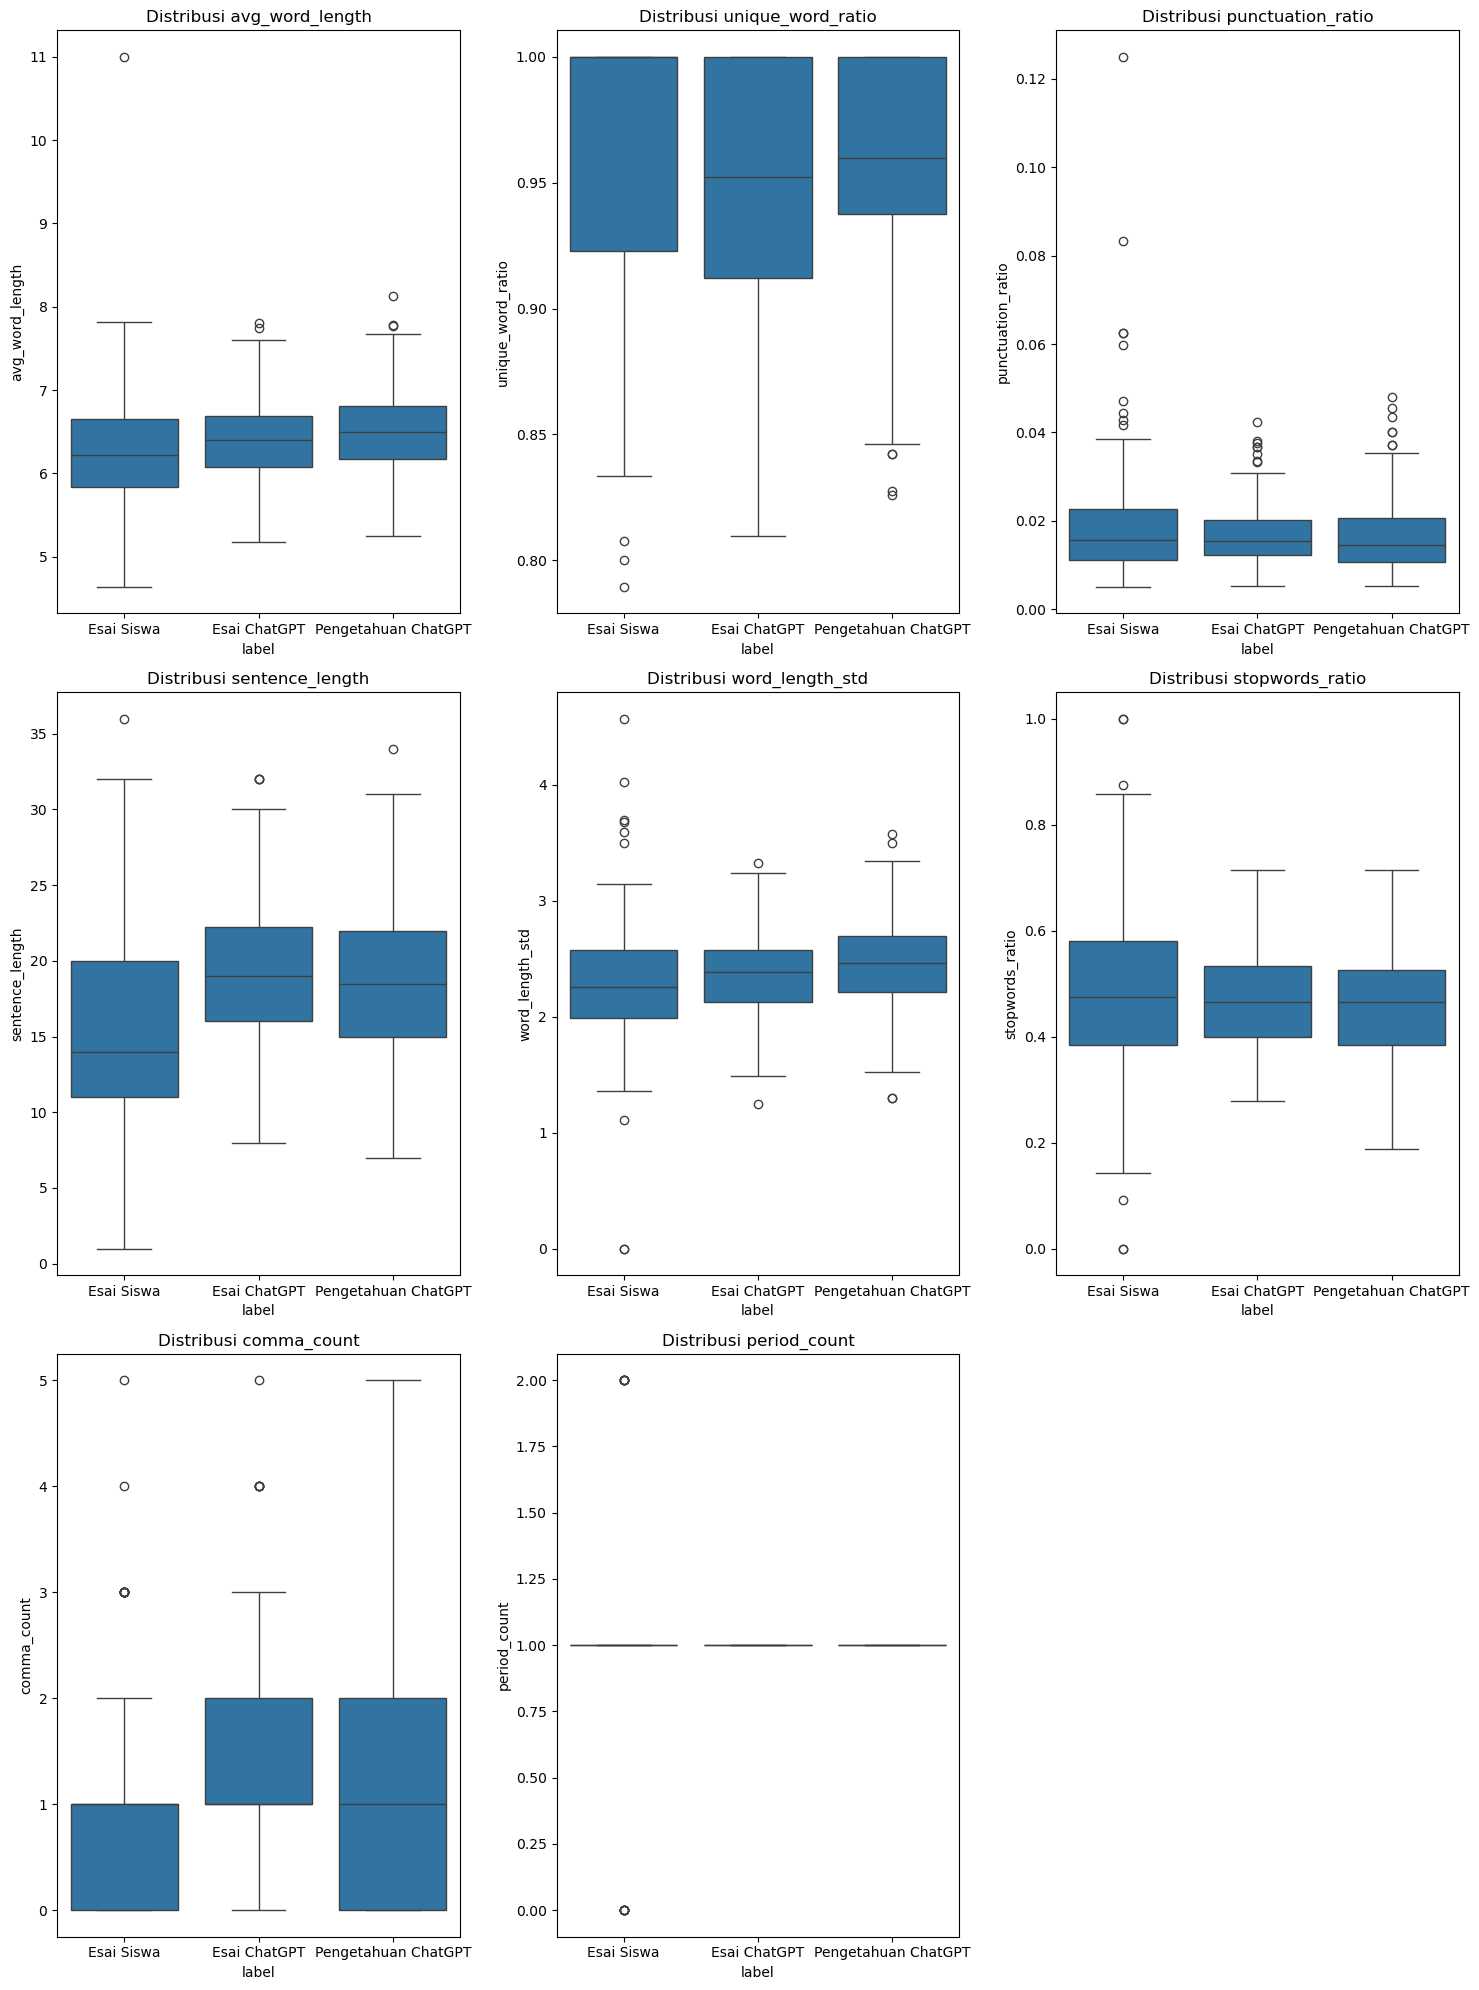

In [69]:
plt.figure(figsize=(15, 20))
for i, feature in enumerate([
    'avg_word_length', 
    'unique_word_ratio', 
    'punctuation_ratio', 
    'sentence_length', 
    'word_length_std',  
    'stopwords_ratio', 
    'comma_count', 
    'period_count'
]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='label', y=feature, data=combined_features)
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()

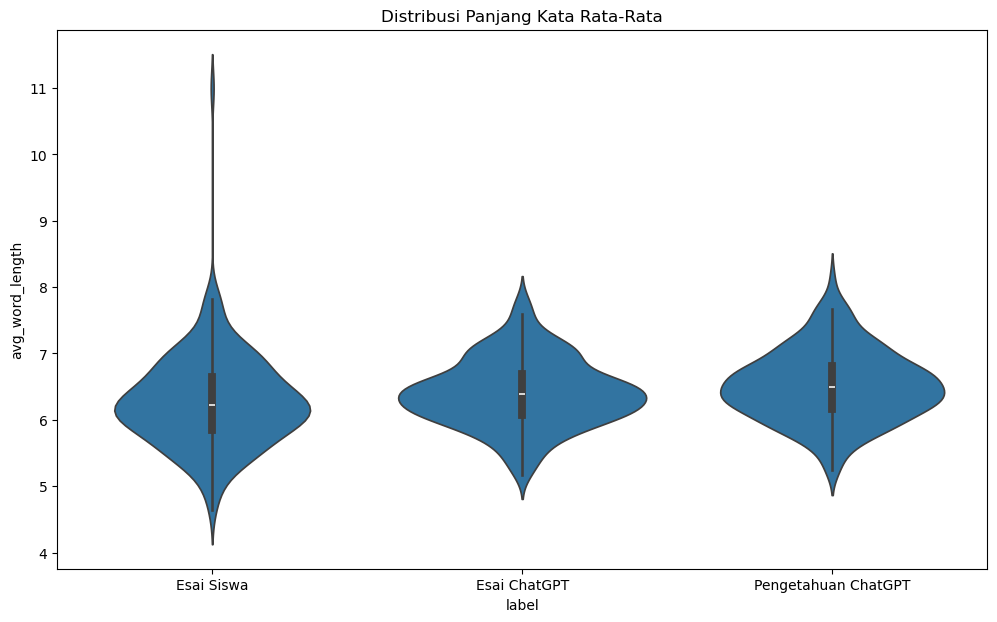

In [70]:
plt.figure(figsize=(12, 7))
sns.violinplot(x='label', y='avg_word_length', data=combined_features, inner='box')
plt.title('Distribusi Panjang Kata Rata-Rata')
plt.show()

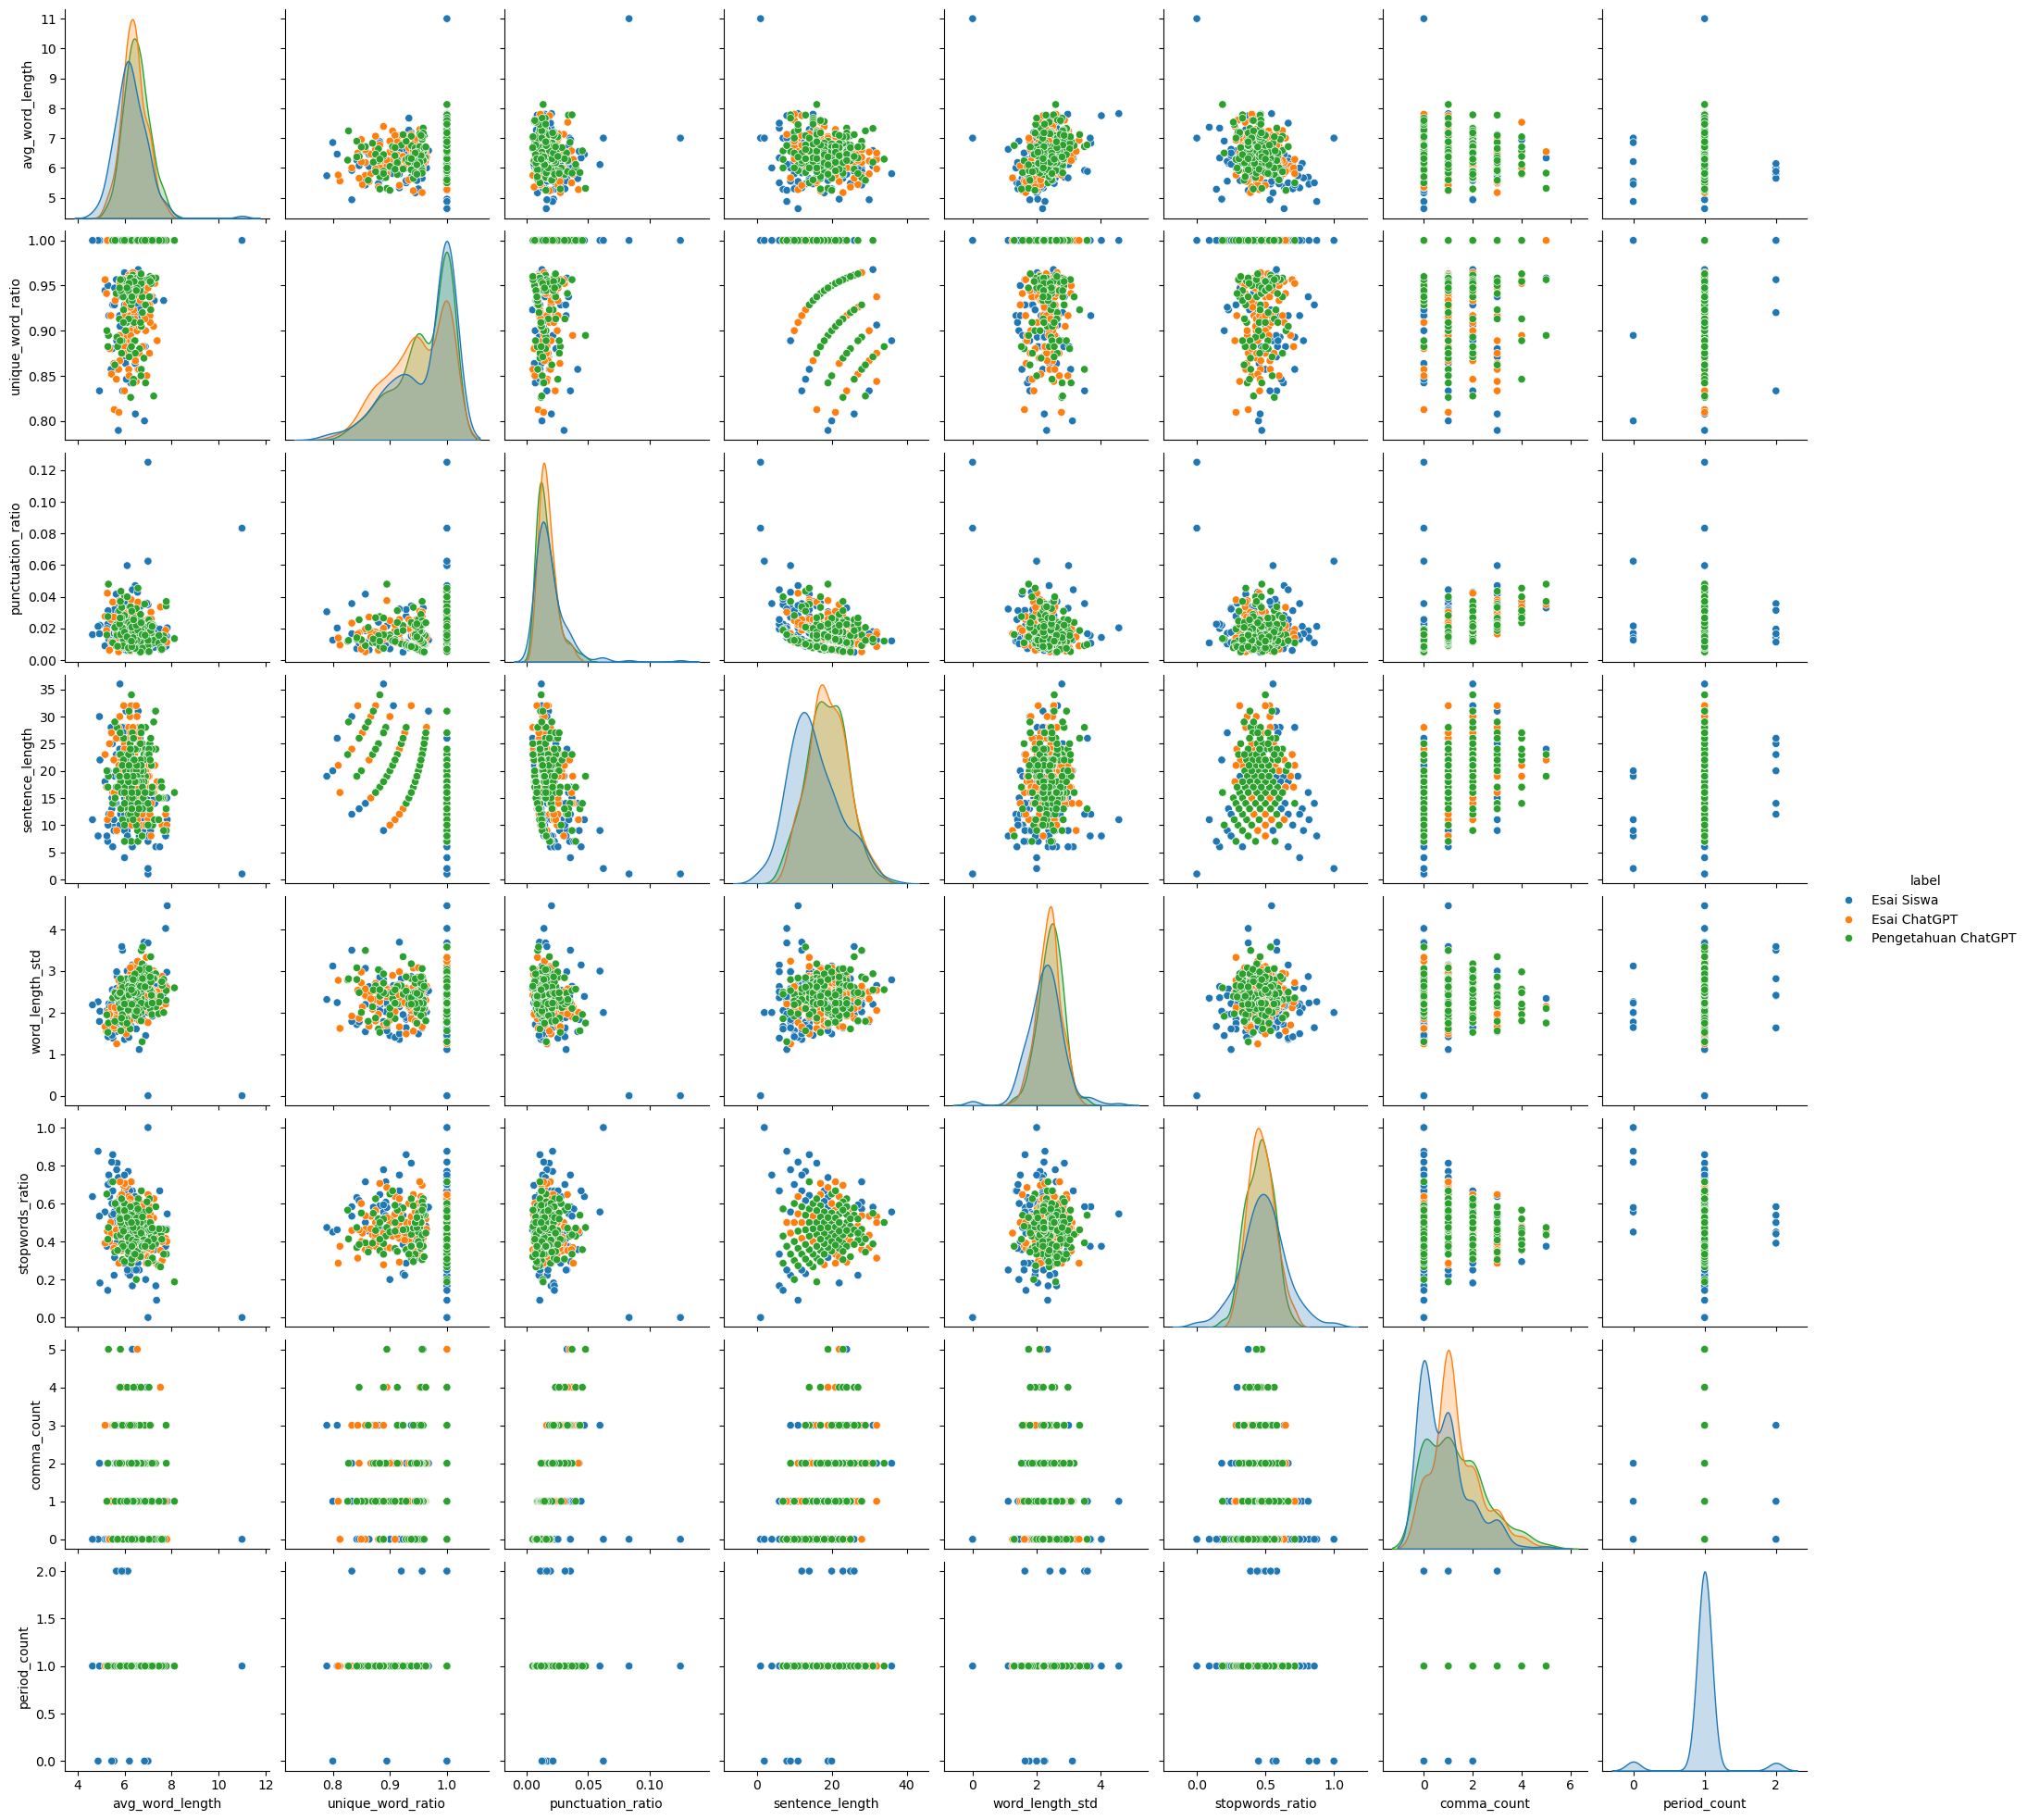

In [71]:
sns.pairplot(combined_features, hue='label', vars=['avg_word_length', 
    'unique_word_ratio', 
    'punctuation_ratio', 
    'sentence_length', 
    'word_length_std', 
    'stopwords_ratio', 
    'comma_count', 
    'period_count'])
plt.show()



## 13. Persiapan Data

In [72]:
print(f"student_similarity_scores shape: {student_similarity_scores_balanced.shape}")
print(f"chatgpt1_similarity_scores shape: {chatgpt1_similarity_scores_balanced.shape}")
print(f"chatgpt2_similarity_scores shape: {chatgpt2_similarity_scores_balanced.shape}")

student_similarity_scores shape: (3, 168)
chatgpt1_similarity_scores shape: (3, 168)
chatgpt2_similarity_scores shape: (3, 168)


In [89]:
# Combine embeddings for model 1 (already correct)
embeddings_model_1 = np.vstack([student_emb1_balanced.numpy(), chatgpt1_emb1_balanced.numpy()])
embeddings_model_2 = np.vstack([student_emb2_balanced.numpy(), chatgpt1_emb2_balanced.numpy()])

student_features_selected = student_features_normalized
chatgpt_features_selected = chatgpt_features_1_normalized

all_stylometric_features = np.vstack([
    student_features_selected,
    chatgpt_features_selected
])

all_similarity_scores = np.vstack([
    student_similarity_scores_balanced,
    chatgpt1_similarity_scores_balanced,
])
all_similarity_scores = all_similarity_scores.T.reshape(len(embeddings_model_1), 3)

# Create labels
student_labels = np.zeros(len(student_embeddings_1))  # Label 0 for Student
chatgpt_labels = np.ones(len(chatgpt1_emb1_balanced))  # Label 1 for ChatGPT
all_labels = np.hstack([student_labels, chatgpt_labels])

# Verify shapes
print(f"embeddings_model_1 shape: {embeddings_model_1.shape}")
print(f"embeddings_model_2 shape: {embeddings_model_2.shape}")
print(f"all_stylometric_features shape: {all_stylometric_features.shape}")
print(f"all_similarity_scores shape: {all_similarity_scores.shape}")
print(f"all_labels shape: {all_labels.shape}")


embeddings_model_1 shape: (336, 128)
embeddings_model_2 shape: (336, 128)
all_stylometric_features shape: (336, 8)
all_similarity_scores shape: (336, 3)
all_labels shape: (336,)


## 14. Membuat Model Single Sentence Classifier

Model classifier dibuat untuk membedakan teks berdasarkan tiga input:
1. Embeddings BERT: Representasi teks dari Bi-Encoder.
2. Fitur Stylometric: Representasi linguistik tambahan.
3. Similarity Score: Skor kesamaan embeddings.

Arsitektur classifier:
- Tiga input terpisah dihubungkan melalui dense layers.
- Output berupa probabilitas apakah teks berasal dari Student atau ChatGPT.

In [90]:
# Persiapkan similarity scores untuk input model
# Gabungkan similarity scores dari ketiga model
student_similarity_combined = np.column_stack([
    student_similarity_scores,
    np.zeros_like(student_similarity_scores),  # Placeholder untuk ChatGPT1
])

chatgpt1_similarity_combined = np.column_stack([
    np.zeros_like(chatgpt1_similarity_scores),  # Placeholder untuk Student
    chatgpt1_similarity_scores,
])

chatgpt2_similarity_combined = np.column_stack([
    np.zeros_like(chatgpt2_similarity_scores),  # Placeholder untuk Student/ChatGPT
    chatgpt2_similarity_scores[:len(chatgpt1_similarity_scores)]  # Ambil sebanyak data ChatGPT1
])

# Input layers untuk tiga jenis fitur
bert_embedding_input_1 = tf.keras.layers.Input(
    shape=(128,),  # Shape embeddings (diambil dari output model bi-encoder Student_ChatGPT)
    dtype=tf.float32, 
    name="bert_embedding_1"
)
bert_embedding_input_2 = tf.keras.layers.Input(
    shape=(128,),  # Shape embeddings (diambil dari output model bi-encoder Only_ChatGPT)
    dtype=tf.float32, 
    name="bert_embedding_2"
)
stylometric_input = tf.keras.layers.Input(
    shape=(8,),  # Shape jumlah fitur stylometric
    dtype=tf.float32, 
    name="stylometric_features"
)
similarity_score_input = tf.keras.layers.Input(
    shape=(3,),  # Shape score similarity (Student, ChatGPT1, ChatGPT2)
    dtype=tf.float32, 
    name="similarity_score"
)

# Dense layer untuk masing-masing input
bert_dense_1 = tf.keras.layers.Dense(128, activation="relu")(bert_embedding_input_1)
bert_dense_2 = tf.keras.layers.Dense(128, activation="relu")(bert_embedding_input_2)
style_dense = tf.keras.layers.Dense(64, activation="relu")(stylometric_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(similarity_score_input)

# Gabungkan semua fitur
combined = tf.keras.layers.Concatenate()([bert_dense_1, bert_dense_2, style_dense, sim_dense])

# Dense layers untuk klasifikasi
x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Buat model classifier
classifier = tf.keras.Model(
    inputs=[bert_embedding_input_1, bert_embedding_input_2, stylometric_input, similarity_score_input],
    outputs=output,
    name="text_classifier"
)

# Compile model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Tampilkan arsitektur model
classifier.summary()

Model: "text_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_embedding_1 (InputLay  [(None, 128)]                0         []                            
 er)                                                                                              
                                                                                                  
 bert_embedding_2 (InputLay  [(None, 128)]                0         []                            
 er)                                                                                              
                                                                                                  
 stylometric_features (Inpu  [(None, 8)]                  0         []                            
 tLayer)                                                                            

## 15. Membuat Data Training

Data untuk training dan validation dibuat dengan menggabungkan:
- Embeddings dari Bi-Encoder.
- Fitur stylometric yang telah dinormalisasi.
- Similarity scores.
- Label: 0 untuk Student dan 1 untuk ChatGPT.

Dataset kemudian dibagi menjadi training dan validation.

In [91]:
# Split data into training, validation, and test sets
train_idx, temp_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.3,
    random_state=42,
    stratify=all_labels
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.33,  # 10% dari total (0.33 * 0.3 = 0.1)
    random_state=42,
    stratify=all_labels[temp_idx]
)

# Prepare inputs for training, validation, and test
train_inputs = {
    "bert_embedding_1": embeddings_model_1[train_idx],
    "bert_embedding_2": embeddings_model_2[train_idx],
    "stylometric_features": all_stylometric_features[train_idx],
    "similarity_score": all_similarity_scores[train_idx]
}

val_inputs = {
    "bert_embedding_1": embeddings_model_1[val_idx],
    "bert_embedding_2": embeddings_model_2[val_idx],
    "stylometric_features": all_stylometric_features[val_idx],
    "similarity_score": all_similarity_scores[val_idx]
}

test_inputs = {
    "bert_embedding_1": embeddings_model_1[test_idx],
    "bert_embedding_2": embeddings_model_2[test_idx],
    "stylometric_features": all_stylometric_features[test_idx],
    "similarity_score": all_similarity_scores[test_idx]
}

train_labels = all_labels[train_idx]
val_labels = all_labels[val_idx]
test_labels = all_labels[test_idx]

## 16. Train Model Classifier

Model classifier dilatih menggunakan dataset yang telah disiapkan. `Callback EarlyStopping` digunakan untuk menghentikan pelatihan jika performa tidak meningkat.

In [92]:
tf.config.run_functions_eagerly(True)

Training Text Classifier...
Epoch 1/20


1/8 [==>...........................] - ETA: 0s - loss: 0.6693 - accuracy: 0.5938 - precision_1: 0.6667 - recall_1: 0.2667 - auc_1: 0.6569

/home/training/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - 1s 103ms/step - loss: 0.6798 - accuracy: 0.6043 - precision_1: 0.6712 - recall_1: 0.4153 - auc_1: 0.6600 - val_loss: 0.6647 - val_accuracy: 0.7015 - val_precision_1: 0.7600 - val_recall_1: 0.5758 - val_auc_1: 0.8155
Epoch 2/20
8/8 [==============================] - 1s 95ms/step - loss: 0.6596 - accuracy: 0.7532 - precision_1: 0.8488 - recall_1: 0.6186 - auc_1: 0.8529 - val_loss: 0.6439 - val_accuracy: 0.8657 - val_precision_1: 0.9000 - val_recall_1: 0.8182 - val_auc_1: 0.9216
Epoch 3/20
8/8 [==============================] - 1s 99ms/step - loss: 0.6370 - accuracy: 0.8681 - precision_1: 0.9677 - recall_1: 0.7627 - auc_1: 0.9573 - val_loss: 0.6218 - val_accuracy: 0.9403 - val_precision_1: 0.9677 - val_recall_1: 0.9091 - val_auc_1: 0.9541
Epoch 4/20
8/8 [==============================] - 1s 89ms/step - loss: 0.6142 - accuracy: 0.9319 - precision_1: 0.9904 - recall_1: 0.8729 - auc_1: 0.9855 - val_loss: 0.5973 - val_accuracy: 0.9403 - val_precision_1: 

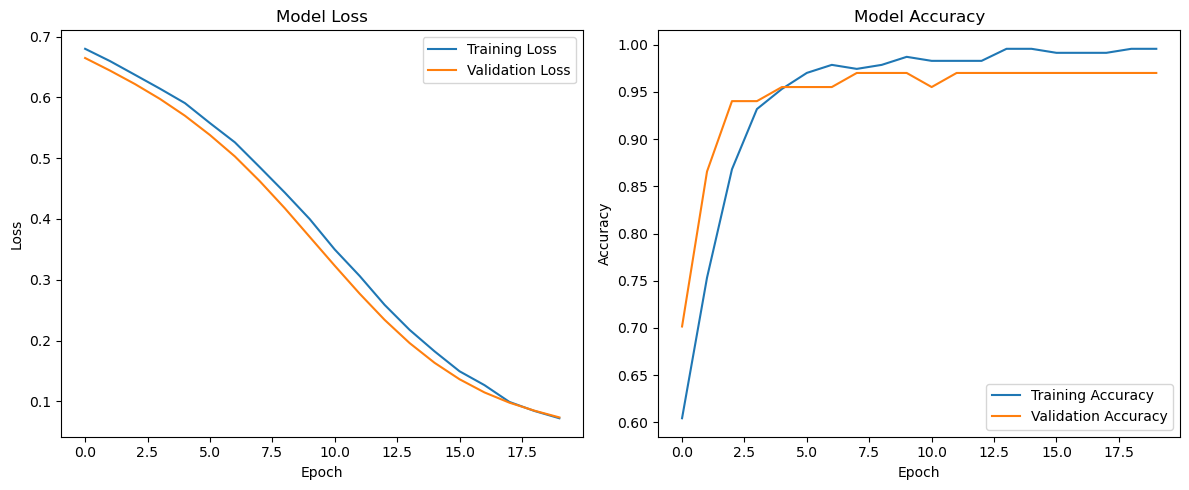

In [93]:
# Training classifier
print("Training Text Classifier...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 17. Evaluasi Model

Model dievaluasi pada dataset validation:
- **Confusion Matrix**: Menampilkan jumlah prediksi benar dan salah untuk masing-masing label.
- **Classification Report**: Menampilkan metrik seperti precision, recall, F1-score, dan accuracy.

3/3 [==============================] - 0s 32ms/step - loss: 0.0735 - accuracy: 0.9701 - precision_1: 1.0000 - recall_1: 0.9394 - auc_1: 1.0000
Validation Loss: 0.0735
Validation Accuracy: 0.9701
Validation Precision: 1.0000
Validation Recall: 0.9394
Validation AUC: 1.0000
3/3 [==============================] - 0s 8ms/step


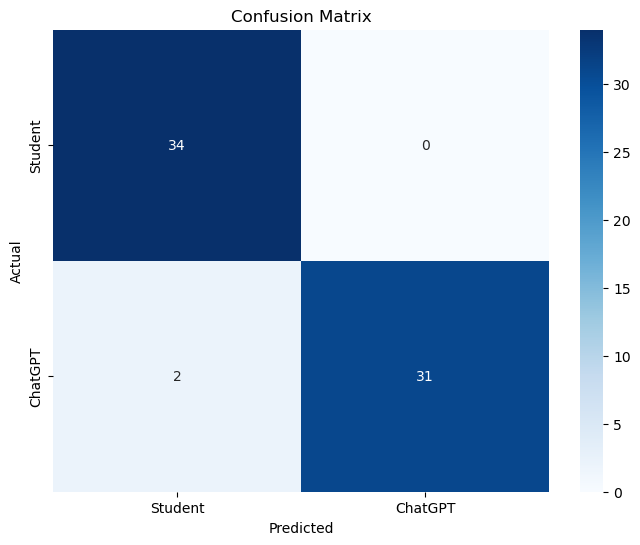


Classification Report:
              precision    recall  f1-score   support

     Student       0.94      1.00      0.97        34
     ChatGPT       1.00      0.94      0.97        33

    accuracy                           0.97        67
   macro avg       0.97      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67

2/2 [==============================] - 0s 40ms/step - loss: 0.0650 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - auc_1: 1.0000
Test Loss: 0.0650
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test AUC: 1.0000
2/2 [==============================] - 0s 8ms/step


/home/training/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


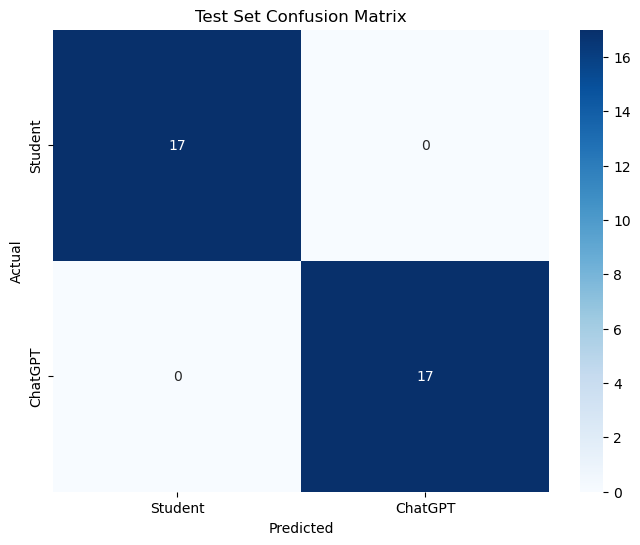


Test Set Classification Report:
              precision    recall  f1-score   support

     Student       1.00      1.00      1.00        17
     ChatGPT       1.00      1.00      1.00        17

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



In [94]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluasi model pada validation set
val_loss, val_acc, val_precision, val_recall, val_auc = classifier.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Prediksi pada validation set
val_predictions = classifier.predict(val_inputs)
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(val_labels, val_predictions_binary)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions_binary, target_names=['Student', 'ChatGPT']))

# Evaluasi model pada test set
test_loss, test_acc, test_precision, test_recall, test_auc = classifier.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Prediksi pada test set
test_predictions = classifier.predict(test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Confusion matrix untuk test set
cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Visualisasi confusion matrix untuk test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report untuk test set
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))

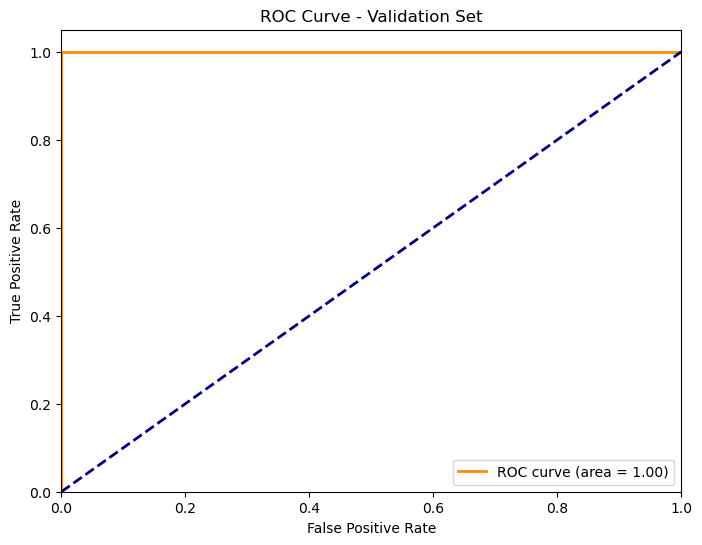

Validation AUC from ROC curve: 1.0000


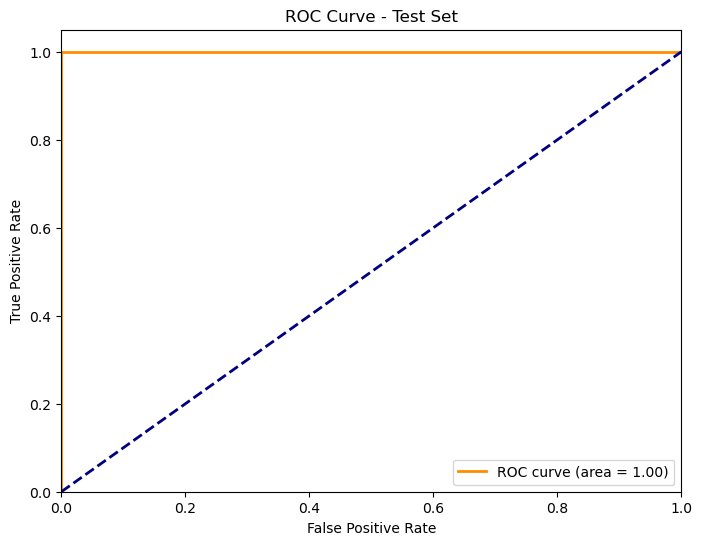

Test AUC from ROC curve: 1.0000


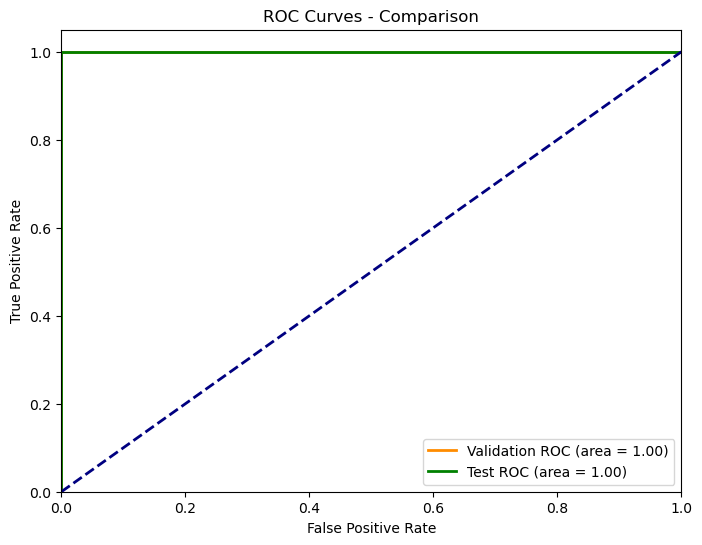

In [95]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fungsi untuk plot ROC curve
def plot_roc_curve(labels, predictions, title):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

# Plot ROC curve untuk validation set
val_auc_score = plot_roc_curve(val_labels, val_predictions, "Validation Set")
print(f"Validation AUC from ROC curve: {val_auc_score:.4f}")

# Plot ROC curve untuk test set
test_auc_score = plot_roc_curve(test_labels, test_predictions, "Test Set")
print(f"Test AUC from ROC curve: {test_auc_score:.4f}")

# Plot kedua kurva ROC dalam satu grafik untuk perbandingan
plt.figure(figsize=(8, 6))

# Validation set
fpr_val, tpr_val, _ = roc_curve(val_labels, val_predictions)
roc_auc_val = auc(fpr_val, tpr_val)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'Validation ROC (area = {roc_auc_val:.2f})')

# Test set
fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions)
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (area = {roc_auc_test:.2f})')

# Garis diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparison')
plt.legend(loc="lower right")
plt.show()

## 18. Simpan Model Classifier

Model classifier yang telah dilatih disimpan bersama dengan konfigurasi tokenizer dan scaler untuk inference di masa depan.

In [96]:
# Buat direktori jika belum ada
if not os.path.exists('saved_models_1_2'):
    os.makedirs('saved_models_1_2')

# Simpan model bi-encoder untuk Student_ChatGPT
bi_encoder_student_chatgpt.save('saved_models_1_2/bi_encoder_student_chatgpt.h5')

# Simpan model bi-encoder untuk Only_ChatGPT
bi_encoder_only_chatgpt.save('saved_models_1_2/bi_encoder_only_chatgpt.h5')

# Simpan model classifier
classifier.save('saved_models_1_2/text_classifier.h5')

# Simpan konfigurasi tokenizer
tokenizer.save_pretrained('saved_models_1_2/tokenizer')

# Simpan scaler untuk fitur stylometric
with open("saved_models_1_2/scaler_stylometric.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model dan konfigurasi berhasil disimpan!")

/home/training/anaconda3/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model dan konfigurasi berhasil disimpan!


In [97]:
%watermark
%watermark -iv --gpu

Last updated: 2025-04-14T20:46:02.881649+07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.27.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

sklearn     : 1.5.1
matplotlib  : 3.9.2
tensorflow  : 2.19.0
re          : 2.2.1
numpy       : 1.26.4
transformers: 4.49.0
pandas      : 2.2.2
seaborn     : 0.13.2

GPU Info: 
  GPU 0: NVIDIA GeForce GTX 1660 SUPER

